### <font color = blue> FORECASTING THE PRICE OF MAJOR CRYPTOCURRENCIES BASED ON HISTORICAL PRICE OF BITCOIN  </font>

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

Importing data for all the cryptocurrencies to be analysed.
- btc ==> Bitcoin
- doge ==> Dogecoin
- eth ==> Ethereum
- ltc ==> Litecoin
- usdt ==> Tether
- usdc ==> USD Coin
- xmr ==> Monero

In [2]:
btc = pd.read_csv('BTC-USD.csv')
xmr = pd.read_csv('XMR-USD.csv')

In [3]:
btc.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,17-09-2014,465.864014,468.174011,452.421997,457.334015,457.334015,21056800.0
1,18-09-2014,456.859985,456.859985,413.104004,424.440002,424.440002,34483200.0
2,19-09-2014,424.102997,427.834991,384.532013,394.795990,394.795990,37919700.0
3,20-09-2014,394.673004,423.295990,389.882996,408.903992,408.903992,36863600.0
4,21-09-2014,408.084991,412.425995,393.181000,398.821014,398.821014,26580100.0


In [4]:
btc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935 entries, 0 to 2934
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2935 non-null   object 
 1   Open       2935 non-null   float64
 2   High       2935 non-null   float64
 3   Low        2935 non-null   float64
 4   Close      2935 non-null   float64
 5   Adj Close  2935 non-null   float64
 6   Volume     2935 non-null   float64
dtypes: float64(6), object(1)
memory usage: 160.6+ KB


In [5]:
xmr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1786 entries, 0 to 1785
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1786 non-null   object 
 1   Open       1786 non-null   float64
 2   High       1786 non-null   float64
 3   Low        1786 non-null   float64
 4   Close      1786 non-null   float64
 5   Adj Close  1786 non-null   float64
 6   Volume     1786 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 97.8+ KB


Here we can conclude that there are no missing values in the entire dataset.

In [6]:
btc['Date'] = pd.to_datetime(btc['Date'], format='%d-%m-%Y')
xmr['Date'] = pd.to_datetime(xmr['Date'], format='%Y-%m-%d')

In [7]:
btc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935 entries, 0 to 2934
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       2935 non-null   datetime64[ns]
 1   Open       2935 non-null   float64       
 2   High       2935 non-null   float64       
 3   Low        2935 non-null   float64       
 4   Close      2935 non-null   float64       
 5   Adj Close  2935 non-null   float64       
 6   Volume     2935 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 160.6 KB


In [8]:
# 'Close' and 'Adj Close' columns have same values, hence dropping one of them
btc.drop(['Adj Close'], axis=1, inplace=True)
xmr.drop(['Adj Close'], axis=1, inplace=True)

#### Lets analyze the data for outliers. First the Volume field for all the currencies.
1. First plot a line plot to see Volume against time and see if there is something unsual
2. Box-Plot for detailed analysis of volume outliers
3. Histogram to check the distribution of volume

#### Lets analyze the price field for all the currencies. We will consider the Closing price.
1. First plot a line plot to see Close price against time and see if there is something unsual
2. Box-Plot for detailed analysis of close price outliers
3. Histogram to check the distribution of close price

Lets proceed with Ethereum for now. It has no volume or price outliers.
We will start with a base models which will only have a univariate ARMA and ARIMA model that will provide us a baseline or the starting point

#### Feature Engineering

In [9]:
btc = btc[['Date', 'Close','Open', 'High', 'Low', 'Volume']]
crypto = btc.merge(xmr,on='Date')
crypto.rename(columns={"Open_x": "Open_btc",
                   "High_x": "High_btc",
                   "Low_x": "Low_btc",
                   "Close_x": "Close_btc",
                   "Volume_x": "Volume_btc",
                   "Open_y": "Open_xmr",
                   "High_y": "High_xmr",
                   "Low_y": "Low_xmr",
                   "Close_y": "Close_xmr",
                   "Volume_y": "Volume_xmr"
                   }, inplace=True)
crypto.head()

,Date,Close_btc,Open_btc,High_btc,Low_btc,Volume_btc,Open_xmr,High_xmr,Low_xmr,Close_xmr,Volume_xmr
0,2017-11-09,7143.580078,7446.830078,7446.830078,7101.520020,3.226250e+09,112.531998,123.404999,112.219002,120.779999,86864600
1,2017-11-10,6618.140137,7173.729980,7312.000000,6436.870117,5.208250e+09,121.344002,121.665001,101.757004,105.585999,84614000
2,2017-11-11,6357.600098,6618.609863,6873.149902,6204.220215,4.908680e+09,105.750000,127.106003,103.877998,119.615997,107708000
3,2017-11-12,5950.069824,6295.450195,6625.049805,5519.009766,8.957350e+09,119.597000,133.675003,110.617996,123.856003,144948000
4,2017-11-13,6559.490234,5938.250000,6811.189941,5844.290039,6.263250e+09,128.960007,136.528000,120.921997,123.402000,116200000


In [10]:
from ta import add_all_ta_features
from ta.utils import dropna

In [11]:
add_all_ta_features(crypto, 
                    open='Open_btc', 
                    high='High_btc', 
                    low='Low_btc', 
                    close='Close_btc', 
                    volume='Volume_btc', 
                    fillna=True)
crypto.head()

,Date,Close_btc,Open_btc,High_btc,Low_btc,Volume_btc,Open_xmr,High_xmr,Low_xmr,Close_xmr,...,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,momentum_pvo,momentum_pvo_signal,momentum_pvo_hist,momentum_kama,others_dr,others_dlr,others_cr
0,2017-11-09,7143.580078,7446.830078,7446.830078,7101.520020,3.226250e+09,112.531998,123.404999,112.219002,120.779999,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7143.580078,-64.665181,0.000000,0.000000
1,2017-11-10,6618.140137,7173.729980,7312.000000,6436.870117,5.208250e+09,121.344002,121.665001,101.757004,105.585999,...,-0.589971,-0.117994,-0.471977,4.687377,0.937475,3.749901,6938.297352,-7.355415,-7.639968,-7.355415
2,2017-11-11,6357.600098,6618.609863,6873.149902,6204.220215,4.908680e+09,105.750000,127.106003,103.877998,119.615997,...,-1.348517,-0.364099,-0.984419,7.350066,2.219993,5.130073,6680.905833,-3.936756,-4.016342,-11.002606
3,2017-11-12,5950.069824,6295.450195,6625.049805,5519.009766,8.957350e+09,119.597000,133.675003,110.617996,123.856003,...,-2.412867,-0.773853,-1.639015,16.784287,5.132852,11.651435,6361.957670,-6.410128,-6.624801,-16.707453
4,2017-11-13,6559.490234,5938.250000,6811.189941,5844.290039,6.263250e+09,128.960007,136.528000,120.921997,123.402000,...,-2.520161,-1.123114,-1.397047,18.239058,7.754093,10.484964,6431.511341,10.242240,9.750994,-8.176430


In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [13]:
from feature_engine.selection import (
    DropDuplicateFeatures,
    DropConstantFeatures,
    DropCorrelatedFeatures,
    SmartCorrelatedSelection,
    SelectByShuffling,
    SelectBySingleFeaturePerformance,
    RecursiveFeatureElimination,
)

In [14]:
y = crypto['Close_xmr']
X = crypto.drop('Close_xmr', axis=1)

In [15]:
X.shape

(1786, 96)

In [16]:
constant = DropConstantFeatures(tol=0.500)
constant.fit(X)

DropConstantFeatures(tol=0.5)

In [17]:
len(constant.features_to_drop_)

6

In [18]:
constant.features_to_drop_

['volatility_bbhi',
 'volatility_bbli',
 'volatility_kchi',
 'volatility_kcli',
 'trend_psar_up_indicator',
 'trend_psar_down_indicator']

In [19]:
X.drop(constant.features_to_drop_, axis=1, inplace=True)
X.shape

(1786, 90)

In [20]:
duplicates = DropDuplicateFeatures()
duplicates.fit(X)

DropDuplicateFeatures()

In [21]:
len(duplicates.features_to_drop_)

0

In [22]:
correlated = DropCorrelatedFeatures(variables=None, method='pearson', threshold=0.7)
correlated.fit(X)

DropCorrelatedFeatures(threshold=0.7)

In [23]:
len(correlated.features_to_drop_)

62

In [24]:
l = list(correlated.features_to_drop_)

In [25]:
X.drop(l, axis=1, inplace=True)
X.shape

(1786, 28)

In [26]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1786 entries, 0 to 1785
Data columns (total 28 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Date               1786 non-null   datetime64[ns]
 1   Close_btc          1786 non-null   float64       
 2   Volume_btc         1786 non-null   float64       
 3   Open_xmr           1786 non-null   float64       
 4   Volume_xmr         1786 non-null   int64         
 5   volume_cmf         1786 non-null   float64       
 6   volume_fi          1786 non-null   float64       
 7   volume_em          1786 non-null   float64       
 8   volume_sma_em      1786 non-null   float64       
 9   volume_vpt         1786 non-null   float64       
 10  volume_mfi         1786 non-null   float64       
 11  volume_nvi         1786 non-null   float64       
 12  volatility_bbw     1786 non-null   float64       
 13  volatility_kcp     1786 non-null   float64       
 14  volatili

In [27]:
smart_correlated = SmartCorrelatedSelection(variables=None, 
                                            method='pearson', 
                                            threshold=0.7, 
                                            missing_values='ignore', 
                                            selection_method='missing_values', 
                                            estimator=None, 
                                            scoring='roc_auc', 
                                            cv=3)
smart_correlated.fit(X)

SmartCorrelatedSelection(threshold=0.7)

In [28]:
smart_correlated.correlated_feature_sets_

[]

In [29]:
len(smart_correlated.features_to_drop_)

0

In [30]:
from sklearn.linear_model import LinearRegression
linear_model = LinearRegression()
SBS_model = SelectByShuffling(estimator=linear_model, scoring="r2", cv=3)
SBS = SBS_model.fit_transform(X, y)

In [31]:
SBS_model.initial_model_performance_

0.7607165514323561

In [32]:
SBS_model.performance_drifts_

{'Close_btc': 0.008514413639815865,
 'Volume_btc': 0.005479200661472783,
 'Open_xmr': 5.57454687194815,
 'Volume_xmr': 0.006765615236263844,
 'volume_cmf': 0.0024373610231113174,
 'volume_fi': -0.0006368988872981207,
 'volume_em': 0.0025944696368326303,
 'volume_sma_em': 0.0016010158629167215,
 'volume_vpt': 0.0010289068191255968,
 'volume_mfi': -0.00041716876207775755,
 'volume_nvi': 0.003605223708543326,
 'volatility_bbw': 0.00015368701712759059,
 'volatility_kcp': 0.0017957777181178969,
 'volatility_ui': 0.0032671219118255435,
 'trend_macd_signal': 0.0020235784544262447,
 'trend_trix': -0.0016536857967384133,
 'trend_mass_index': 7.947087616100301e-05,
 'trend_dpo': 0.00014800846724660754,
 'trend_kst_sig': 0.005195065347135985,
 'trend_kst_diff': 0.0017625282939419673,
 'trend_stc': 0.0007968069344610473,
 'trend_adx': 0.0011882383661170337,
 'trend_aroon_up': 0.00013021316949246575,
 'trend_aroon_down': 0.00023683347126590704,
 'momentum_pvo': -0.001849689287107048,
 'momentum_pvo

In [33]:
sorted_sbs_var = {var: val for var, val in sorted(SBS_model.performance_drifts_.items(), key=lambda item: item[1])}

In [34]:
sorted_sbs_var

{'momentum_pvo': -0.001849689287107048,
 'trend_trix': -0.0016536857967384133,
 'volume_fi': -0.0006368988872981207,
 'volume_mfi': -0.00041716876207775755,
 'trend_mass_index': 7.947087616100301e-05,
 'trend_aroon_up': 0.00013021316949246575,
 'trend_dpo': 0.00014800846724660754,
 'volatility_bbw': 0.00015368701712759059,
 'trend_aroon_down': 0.00023683347126590704,
 'momentum_pvo_hist': 0.0004483735769744701,
 'trend_stc': 0.0007968069344610473,
 'volume_vpt': 0.0010289068191255968,
 'trend_adx': 0.0011882383661170337,
 'volume_sma_em': 0.0016010158629167215,
 'trend_kst_diff': 0.0017625282939419673,
 'volatility_kcp': 0.0017957777181178969,
 'trend_macd_signal': 0.0020235784544262447,
 'volume_cmf': 0.0024373610231113174,
 'volume_em': 0.0025944696368326303,
 'volatility_ui': 0.0032671219118255435,
 'volume_nvi': 0.003605223708543326,
 'trend_kst_sig': 0.005195065347135985,
 'Volume_btc': 0.005479200661472783,
 'Volume_xmr': 0.006765615236263844,
 'Close_btc': 0.008514413639815865,


In [35]:
sfp = SelectBySingleFeaturePerformance(estimator=LinearRegression(), scoring="r2", cv=3, threshold=0.01)
sfp.fit(X, y)

SelectBySingleFeaturePerformance(estimator=LinearRegression(), scoring='r2',
                                 threshold=0.01)

In [36]:
sorted_sfp_var = {var: val for var, val in sorted(sfp.feature_performance_.items(), key=lambda item: item[1])}
sorted_sfp_var

{'Volume_xmr': -45.303552058317905,
 'Volume_btc': -5.28202442403079,
 'volume_cmf': -4.582351155046195,
 'trend_kst_sig': -4.318036926094064,
 'trend_macd_signal': -4.259454031956024,
 'trend_mass_index': -4.0738247133532965,
 'trend_trix': -4.021370063489865,
 'trend_stc': -4.015566461734826,
 'momentum_pvo': -4.001635859495041,
 'volume_mfi': -3.9999363139665483,
 'trend_adx': -3.996514369193175,
 'trend_dpo': -3.9941541147848802,
 'volume_fi': -3.9890878249442405,
 'volatility_kcp': -3.982045028144926,
 'trend_kst_diff': -3.9803165671429266,
 'trend_aroon_up': -3.978935151902286,
 'momentum_pvo_hist': -3.977972727786715,
 'trend_aroon_down': -3.9774798259041013,
 'volume_sma_em': -3.976907061748388,
 'others_dr': -3.9725459688637925,
 'volume_em': -3.964847904134054,
 'volume_vpt': -3.960039844246784,
 'volatility_bbw': -3.8676310687721056,
 'volatility_ui': -3.7406911032089347,
 'volume_nvi': -2.8490279589900944,
 'Close_btc': -1.067786515366867,
 'Open_xmr': 0.9712688992061499}

In [37]:
lr = LinearRegression()
lr_model = RecursiveFeatureElimination(estimator=lr, scoring="r2", cv=3)
lr_model.fit_transform(X, y)
lr_model.initial_model_performance_

0.7607165514323561

In [38]:
lr_model.performance_drifts_

{'volume_fi': 0.011001078753456017,
 'Volume_btc': -0.055207628775910456,
 'volume_vpt': 0.012409917781872393,
 'Volume_xmr': -0.13549985862939085,
 'trend_dpo': -0.0006729436713169834,
 'volume_sma_em': 0.0010871383323418637,
 'Close_btc': -0.011890211415256258,
 'volume_em': 0.0037231314423363804,
 'trend_macd_signal': -0.0018190495098483472,
 'trend_aroon_down': -0.0011610761808121817,
 'trend_aroon_up': -0.0006714178499094281,
 'trend_stc': -0.0004995575515812645,
 'trend_kst_sig': -0.0053288620488157745,
 'trend_kst_diff': 4.8375814124090866e-05,
 'volume_nvi': -0.0020637796779062745,
 'volume_mfi': 5.845389924863387e-05,
 'trend_adx': 0.00024459411329869063,
 'volatility_bbw': -0.00045411222646962734,
 'trend_mass_index': -0.00013231357856002823,
 'momentum_pvo': -0.00015006393283234498,
 'momentum_pvo_hist': 0.0005454250146431638,
 'volatility_ui': -0.0005055657789959644,
 'Open_xmr': 5.7840902577158,
 'volatility_kcp': -9.424944211389175e-05,
 'others_dr': 0.006395314771416083,

In [39]:
sorted_lr_var = {var: val for var, val in sorted(lr_model.performance_drifts_.items(), key=lambda item: item[1])}
sorted_lr_var

{'Volume_xmr': -0.13549985862939085,
 'Volume_btc': -0.055207628775910456,
 'Close_btc': -0.011890211415256258,
 'trend_kst_sig': -0.0053288620488157745,
 'volume_nvi': -0.0020637796779062745,
 'trend_macd_signal': -0.0018190495098483472,
 'trend_aroon_down': -0.0011610761808121817,
 'trend_dpo': -0.0006729436713169834,
 'trend_aroon_up': -0.0006714178499094281,
 'volume_cmf': -0.000546324283738242,
 'volatility_ui': -0.0005055657789959644,
 'trend_stc': -0.0004995575515812645,
 'volatility_bbw': -0.00045411222646962734,
 'momentum_pvo': -0.00015006393283234498,
 'trend_mass_index': -0.00013231357856002823,
 'volatility_kcp': -9.424944211389175e-05,
 'trend_trix': -6.148636132485841e-05,
 'trend_kst_diff': 4.8375814124090866e-05,
 'volume_mfi': 5.845389924863387e-05,
 'trend_adx': 0.00024459411329869063,
 'momentum_pvo_hist': 0.0005454250146431638,
 'volume_sma_em': 0.0010871383323418637,
 'volume_em': 0.0037231314423363804,
 'others_dr': 0.006395314771416083,
 'volume_fi': 0.011001078

In [40]:
X.shape

(1786, 28)

In [41]:
# With aim to have only 10 variables in the final dataset, dropping the 16 least impacting variables based on the above models
X.drop(['Volume_xmr',
        'momentum_pvo',
        'volume_mfi',
        'trend_aroon_down',
        'trend_aroon_up',
        'trend_dpo',
        'volume_fi',
        'trend_mass_index',
        'trend_adx',
        'trend_trix',
        'momentum_pvo_hist',
        'trend_stc',
        'trend_macd_signal',
        'trend_kst_diff',
        'volume_vpt',
        'volume_cmf',
        'Volume_btc',
        'trend_kst_sig'
        ], axis=1, inplace=True)

In [42]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1786 entries, 0 to 1785
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Date            1786 non-null   datetime64[ns]
 1   Close_btc       1786 non-null   float64       
 2   Open_xmr        1786 non-null   float64       
 3   volume_em       1786 non-null   float64       
 4   volume_sma_em   1786 non-null   float64       
 5   volume_nvi      1786 non-null   float64       
 6   volatility_bbw  1786 non-null   float64       
 7   volatility_kcp  1786 non-null   float64       
 8   volatility_ui   1786 non-null   float64       
 9   others_dr       1786 non-null   float64       
dtypes: datetime64[ns](1), float64(9)
memory usage: 153.5 KB


In [43]:
#X.to_excel('output.xlsx')

### Defining the Base Model for Monero

The ARMA models are univariate models, hence having the date fields as Index and closing price as the field to be predicted

In [44]:
base = xmr[['Date', 'Close']]
base = base.set_index('Date')
base.head()

,Close
Date,
2017-11-09,120.779999
2017-11-10,105.585999
2017-11-11,119.615997
2017-11-12,123.856003
2017-11-13,123.402000


#### Check for seasionality using Additive & Multiplicative decompositions
#### Additive seasonal decomposition

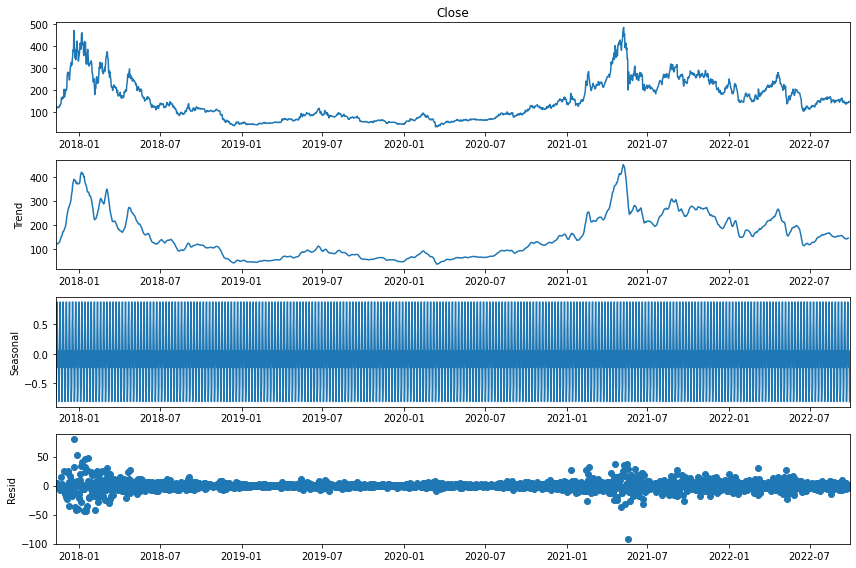

In [45]:
from pylab import rcParams
import statsmodels.api as sm
rcParams['figure.figsize'] = 12, 8
decomposition = sm.tsa.seasonal_decompose(base.Close, model='additive') # additive seasonal index
fig = decomposition.plot()
plt.show()

#### Multiplicative seasonal decomposition

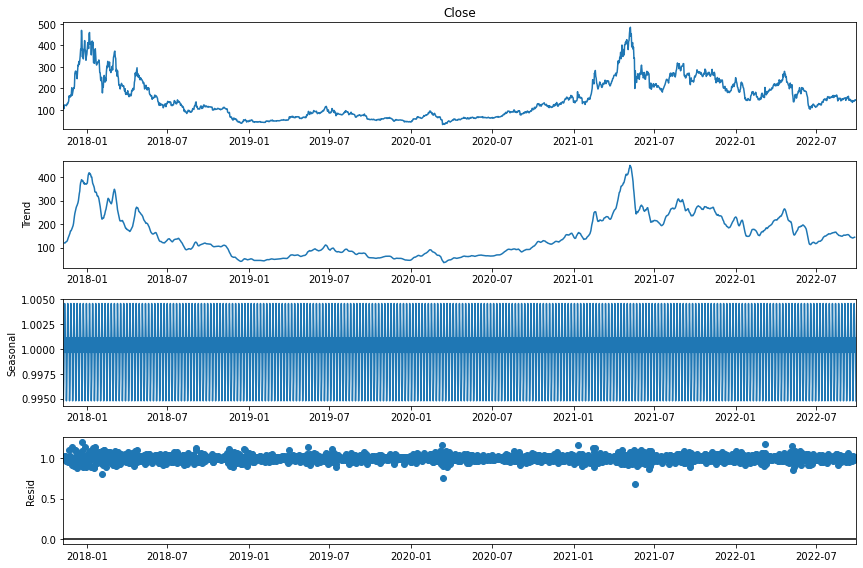

In [46]:
decomposition = sm.tsa.seasonal_decompose(base.Close, model='multiplicative') # multiplicative seasonal index
fig = decomposition.plot()
plt.show()

On analyzing the models, we can conclude that there is high fluctuation in closing price, but a pattern is present to indicate patterns repeating 52 times a year. Hence, we will use seasionality as 52 when required.

#### Train-Test split

In [47]:
base.shape

(1786, 1)

In [48]:
train_len = 1700
train = base[0:train_len]
test = base[train_len:]
print('train : ', train.shape )
print('test : ', test.shape )

train :  (1700, 1)
test :  (86, 1)


#### Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test for stationarity

In [49]:
from statsmodels.tsa.stattools import kpss
kpss_test = kpss(base['Close'])

print('KPSS Statistic: %f' % kpss_test[0])
print('Critical Values @ 0.05: %.2f' % kpss_test[3]['5%'])
print('p-value: %f' % kpss_test[1])

KPSS Statistic: 1.348782
Critical Values @ 0.05: 0.46
p-value: 0.010000


C:\Users\nikhi\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1874: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(warn_msg.format(direction="smaller"), InterpolationWarning)


Since, the p-value is less than 0.05, we can conclude that the data is non-stationary.

#### Box Cox transformation to make variance constant

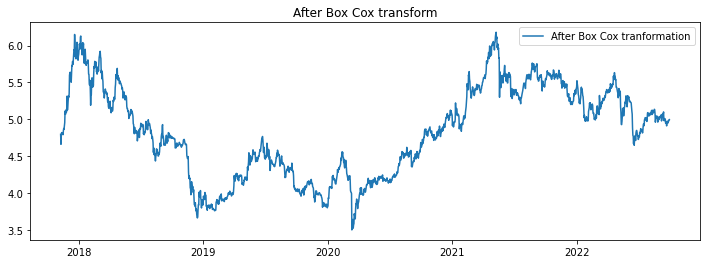

In [50]:
from scipy.stats import boxcox
base_boxcox = pd.Series(boxcox(base['Close'], lmbda=0), index = base.index)

plt.figure(figsize=(12,4))
plt.plot(base_boxcox, label='After Box Cox tranformation')
plt.legend(loc='best')
plt.title('After Box Cox transform')
plt.show()

#### Differencing to remove trend

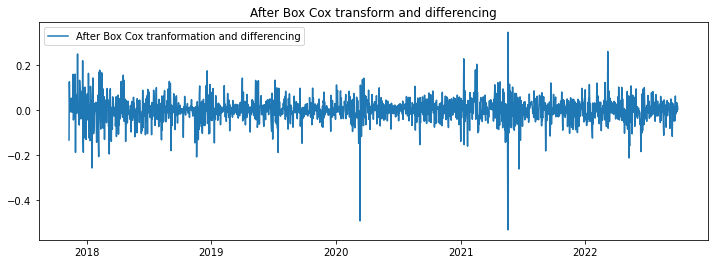

In [51]:
base_boxcox_diff = pd.Series(base_boxcox - base_boxcox.shift(), base.index)
plt.figure(figsize=(12,4))
plt.plot(base_boxcox_diff, label='After Box Cox tranformation and differencing')
plt.legend(loc='best')
plt.title('After Box Cox transform and differencing')
plt.show()

In [52]:
base_boxcox_diff.dropna(inplace=True)
base_boxcox_diff.head()

Date
2017-11-10   -0.134445
2017-11-11    0.124761
2017-11-12    0.034833
2017-11-13   -0.003672
2017-11-14   -0.008537
dtype: float64

#### Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test for stationarity

In [53]:
kpss_test = kpss(base_boxcox_diff)

print('KPSS Statistic: %f' % kpss_test[0])
print('Critical Values @ 0.05: %.2f' % kpss_test[3]['5%'])
print('p-value: %f' % kpss_test[1])

KPSS Statistic: 0.070927
Critical Values @ 0.05: 0.46
p-value: 0.100000


C:\Users\nikhi\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1876: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(warn_msg.format(direction="greater"), InterpolationWarning)


Since the p-value > 0.05, we can say the transformed series is stationary

#### ACF & PCF plots

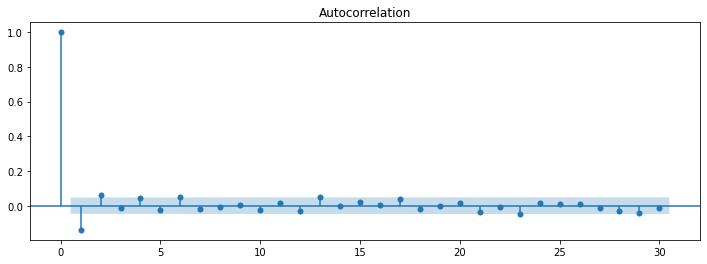

In [54]:
from statsmodels.graphics.tsaplots import plot_acf
plt.figure(figsize=(12,4))
plot_acf(base_boxcox_diff, ax=plt.gca(), lags = 30)
plt.show()

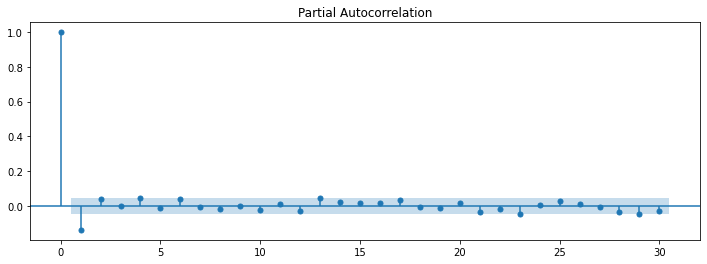

In [55]:
from statsmodels.graphics.tsaplots import plot_pacf
plt.figure(figsize=(12,4))
plot_pacf(base_boxcox_diff, ax=plt.gca(), lags = 30)
plt.show()

In [56]:
train_data_boxcox = base_boxcox[:train_len]
test_data_boxcox = base_boxcox[train_len:]
train_data_boxcox_diff = base_boxcox_diff[:train_len-1]
test_data_boxcox_diff = base_boxcox_diff[train_len-1:]

In [57]:
train_data_boxcox_diff.shape

(1699,)

#### Base model - Auto regression moving average method (ARMA)

In [58]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(train_data_boxcox_diff, order=(1, 0, 1))
model_fit = model.fit()
print(model_fit.params)

const      0.000018
ar.L1.y   -0.482782
ma.L1.y    0.354141
dtype: float64


C:\Users\nikhi\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


In [59]:
# Reverse calculation to extract the original series
y_pred = base_boxcox_diff.copy()
y_pred['arma_forecast_boxcox_diff'] = model_fit.predict(base_boxcox_diff.index.min(), base_boxcox_diff.index.max())
y_pred['arma_forecast_boxcox'] = y_pred['arma_forecast_boxcox_diff'].cumsum()
y_pred['arma_forecast_boxcox'] = y_pred['arma_forecast_boxcox'].add(base_boxcox[0])
y_pred['arma_forecast'] = np.exp(y_pred['arma_forecast_boxcox'])

#### Plot train, test and forecast

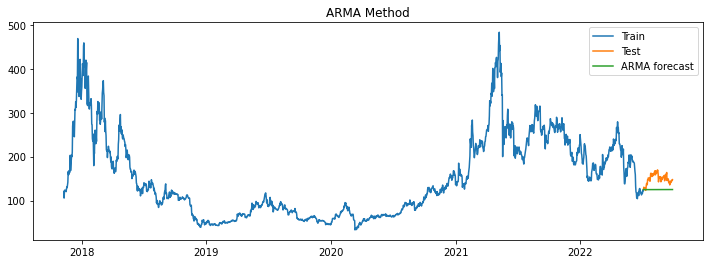

In [60]:
plt.figure(figsize=(12,4))
plt.plot( base['Close'][:train_len], label='Train')
plt.plot(base['Close'][train_len:], label='Test')
plt.plot(y_pred['arma_forecast'][test.index.min():], label='ARMA forecast')
plt.legend(loc='best')
plt.title('ARMA Method')
plt.show()

#### Calculate RMSE and MAPE

In [61]:
test['Close'].shape

(86,)

In [62]:
test.head()

,Close
Date,
2022-07-06,125.494568
2022-07-07,130.436829
2022-07-08,125.617218
2022-07-09,127.173157
2022-07-10,129.157379


In [63]:
y_pred['arma_forecast'][train_len - 1:]

2022-07-06    125.034949
2022-07-07    124.761683
2022-07-08    124.896917
2022-07-09    124.834989
2022-07-10    124.868263
                 ...    
2022-09-25    125.033810
2022-09-26    125.036093
2022-09-27    125.038375
2022-09-28    125.040658
2022-09-29    125.042941
Freq: D, Length: 86, dtype: float64

In [64]:
y_pred['arma_forecast'].shape

(1785,)

In [65]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_percentage_error

In [66]:
mse = mean_squared_error(test['Close'], y_pred['arma_forecast'][train_len -1 :]).round(2)
rmse = np.sqrt(mse).round(2)
r2 = r2_score(test['Close'], y_pred['arma_forecast'][train_len -1 :]).round(2)
mape = mean_absolute_percentage_error(test['Close'], y_pred['arma_forecast'][train_len -1 :]).round(4)*100
model_param = pd.DataFrame( columns = ['model', 'MSE','RMSE','R-Squared','MAPE'])

In [67]:
model_param.loc[0] = ['ARMA', mse, rmse, r2, mape]
model_param

,model,MSE,RMSE,R-Squared,MAPE
0,ARMA,742.01,27.24,-5.0,16.16


In [68]:
a = y_pred['arma_forecast']
b = pd.DataFrame(test['Close'])
b = pd.DataFrame(a)
b.columns = ['ARMA']
b['Close'] = test['Close']

#### Auto regressive integrated moving average (ARIMA)

In [69]:
model = ARIMA(train_data_boxcox, order=(1, 1, 1))
model_fit = model.fit()
print(model_fit.params)

const        0.000018
ar.L1.D.y   -0.482782
ma.L1.D.y    0.354141
dtype: float64


C:\Users\nikhi\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\nikhi\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


In [70]:
# Reverse calculation to extract the original series
y_pred = base_boxcox_diff.copy()
y_pred['arma_forecast_boxcox_diff'] = model_fit.predict(base_boxcox_diff.index.min(), base_boxcox_diff.index.max())
y_pred['arma_forecast_boxcox'] = y_pred['arma_forecast_boxcox_diff'].cumsum()
y_pred['arma_forecast_boxcox'] = y_pred['arma_forecast_boxcox'].add(base_boxcox[0])
y_pred['arma_forecast'] = np.exp(y_pred['arma_forecast_boxcox'])

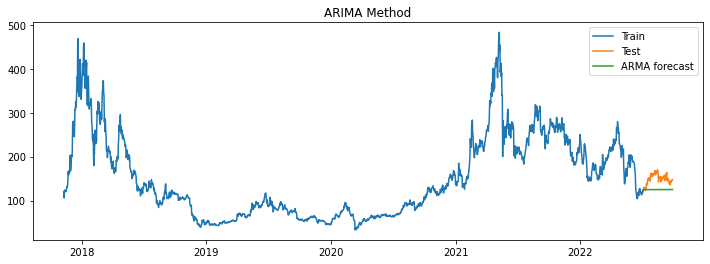

In [71]:
plt.figure(figsize=(12,4))
plt.plot( base['Close'][:train_len], label='Train')
plt.plot(base['Close'][train_len:], label='Test')
plt.plot(y_pred['arma_forecast'][test.index.min():], label='ARMA forecast')
plt.legend(loc='best')
plt.title('ARIMA Method')
plt.show()

#### Calculate RMSE and MAPE

In [72]:
mse = mean_squared_error(test['Close'], y_pred['arma_forecast'][train_len -1 :]).round(2)
rmse = np.sqrt(mse).round(2)
r2 = r2_score(test['Close'], y_pred['arma_forecast'][train_len -1 :]).round(2)
mape = mean_absolute_percentage_error(test['Close'], y_pred['arma_forecast'][train_len -1 :]).round(4)*100

In [73]:
model_param.loc[1] = ['ARIMA', mse, rmse, r2, mape]
model_param

,model,MSE,RMSE,R-Squared,MAPE
0,ARMA,742.01,27.24,-5.0,16.16
1,ARIMA,742.01,27.24,-5.0,16.16


#### SARIMA Model

In [74]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(train_data_boxcox, order=(1, 1, 1), seasonal_order=(1, 1, 1, 52)) 
model_fit = model.fit()
print(model_fit.params)

C:\Users\nikhi\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\nikhi\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


ar.L1      -0.508860
ma.L1       0.378780
ar.S.L52   -0.002017
ma.S.L52   -0.961148
sigma2      0.003250
dtype: float64


In [75]:
# Reverse calculation to extract the original series
y_pred = base_boxcox_diff.copy()
y_pred['sarima_forecast_boxcox'] = model_fit.predict(base_boxcox_diff.index.min(), base_boxcox_diff.index.max())
y_pred['sarima_forecast'] = np.exp(y_pred['sarima_forecast_boxcox'])

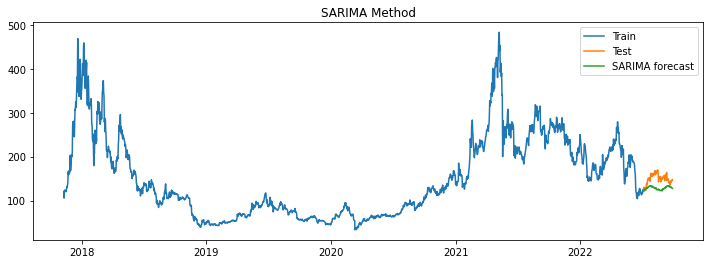

In [76]:
plt.figure(figsize=(12,4))
plt.plot( base['Close'][:train_len], label='Train')
plt.plot(base['Close'][train_len:], label='Test')
plt.plot(y_pred['sarima_forecast'][test.index.min():], label='SARIMA forecast')
plt.legend(loc='best')
plt.title('SARIMA Method')
plt.show()

In [77]:
mse = mean_squared_error(test['Close'], y_pred['sarima_forecast'][test.index.min():]).round(2)
rmse = np.sqrt(mse).round(2)
r2 = r2_score(test['Close'], y_pred['sarima_forecast'][test.index.min():]).round(2)
mape = mean_absolute_percentage_error(test['Close'], y_pred['sarima_forecast'][test.index.min():]).round(4)*100

In [78]:
model_param.loc[2] = ['SARIMA', mse, rmse, r2, mape]
model_param

,model,MSE,RMSE,R-Squared,MAPE
0,ARMA,742.01,27.24,-5.0,16.16
1,ARIMA,742.01,27.24,-5.0,16.16
2,SARIMA,581.36,24.11,-3.7,13.89


In [79]:
a = y_pred['sarima_forecast']
c = pd.DataFrame(a)
c.columns = ['SARIMA']
b = b.join(c)

#### SARIMAX with exogenous variable as Bitcoin data (Only base variables)

In [80]:
base.head()

,Close
Date,
2017-11-09,120.779999
2017-11-10,105.585999
2017-11-11,119.615997
2017-11-12,123.856003
2017-11-13,123.402000


In [81]:
base.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1786 entries, 2017-11-09 to 2022-09-29
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   1786 non-null   float64
dtypes: float64(1)
memory usage: 27.9 KB


In [82]:
btc_exo = btc[['Date', 'Close', 'Volume']]
btc_exo = btc_exo[btc_exo.Date >= '2017-11-09']
btc_exo = btc_exo.set_index('Date')
btc_exo.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1786 entries, 2017-11-09 to 2022-09-29
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   1786 non-null   float64
 1   Volume  1786 non-null   float64
dtypes: float64(2)
memory usage: 41.9 KB


In [83]:
btc_train = btc_exo[:train_len]
btc_test = btc_exo[train_len:]

In [84]:
model = SARIMAX(train_data_boxcox, order=(1, 1, 1), seasonal_order=(1, 1, 1, 52), exog=btc_train) 
SARIMAX_model_fit = model.fit()
print(SARIMAX_model_fit.params)

C:\Users\nikhi\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\nikhi\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\nikhi\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Close       2.876683e-05
Volume     -2.225908e-13
ar.L1      -2.613126e-01
ma.L1       1.029005e-01
ar.S.L52   -1.397161e-01
ma.S.L52   -5.648318e-01
sigma2      4.251129e-03
dtype: float64


In [85]:
# Reverse calculation to extract the original series
y_pred = base_boxcox_diff.copy()
y_pred['sarimax_forecast_boxcox'] = SARIMAX_model_fit.predict(base_boxcox_diff.index.min(), base_boxcox_diff.index.max(), exog=btc_test)
y_pred['sarimax_forecast'] = np.exp(y_pred['sarimax_forecast_boxcox'])

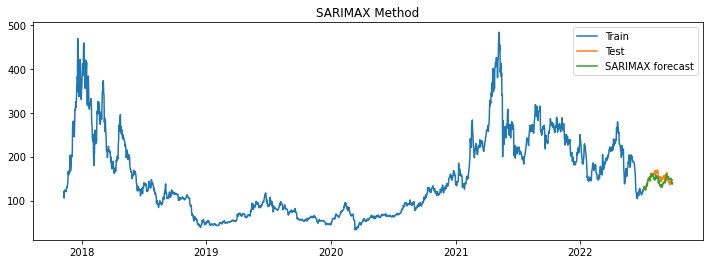

In [86]:
plt.figure(figsize=(12,4))
plt.plot( base['Close'][:train_len], label='Train')
plt.plot(base['Close'][train_len:], label='Test')
plt.plot(y_pred['sarimax_forecast'][test.index.min():], label='SARIMAX forecast')
plt.legend(loc='best')
plt.title('SARIMAX Method')
plt.show()

In [87]:
mse = mean_squared_error(test['Close'], y_pred['sarimax_forecast'][test.index.min():]).round(2)
rmse = np.sqrt(mse).round(2)
r2 = r2_score(test['Close'], y_pred['sarimax_forecast'][test.index.min():]).round(2)
mape = mean_absolute_percentage_error(test['Close'], y_pred['sarimax_forecast'][test.index.min():]).round(4)*100

In [88]:
model_param.loc[3] = ['SARIMAX - BTC Data', mse, rmse, r2, mape]
model_param

,model,MSE,RMSE,R-Squared,MAPE
0,ARMA,742.01,27.24,-5.00,16.16
1,ARIMA,742.01,27.24,-5.00,16.16
2,SARIMA,581.36,24.11,-3.70,13.89
3,SARIMAX - BTC Data,93.22,9.66,0.25,5.30


In [89]:
a = y_pred['sarimax_forecast']
c = pd.DataFrame(a)
c.columns = ['SARIMAX - BTC Data']
b = b.join(c)

#### SARIMAX with exogenous variable as Bitcoin Feature Engineered variables

In [90]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1786 entries, 0 to 1785
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Date            1786 non-null   datetime64[ns]
 1   Close_btc       1786 non-null   float64       
 2   Open_xmr        1786 non-null   float64       
 3   volume_em       1786 non-null   float64       
 4   volume_sma_em   1786 non-null   float64       
 5   volume_nvi      1786 non-null   float64       
 6   volatility_bbw  1786 non-null   float64       
 7   volatility_kcp  1786 non-null   float64       
 8   volatility_ui   1786 non-null   float64       
 9   others_dr       1786 non-null   float64       
dtypes: datetime64[ns](1), float64(9)
memory usage: 153.5 KB


In [91]:
X = X.set_index('Date')
btc_train = X[:train_len]
btc_test = X[train_len:]

In [92]:
train_data_boxcox.head()

Date
2017-11-09    4.793971
2017-11-10    4.659526
2017-11-11    4.784287
2017-11-12    4.819120
2017-11-13    4.815447
dtype: float64

In [93]:
btc_train.head()

,Close_btc,Open_xmr,volume_em,volume_sma_em,volume_nvi,volatility_bbw,volatility_kcp,volatility_ui,others_dr
Date,,,,,,,,,
2017-11-09,7143.580078,112.531998,0.000000,0.000000,1000.000000,0.000000,0.373935,0.0,-64.665181
2017-11-10,6618.140137,121.344002,-6716.736347,-6716.736347,1000.000000,15.272508,0.179064,0.0,-7.355415
2017-11-11,6357.600098,105.750000,-4575.428295,-5646.082321,960.632438,19.497274,0.122845,0.0,-3.936756
2017-11-12,5950.069824,119.597000,-5762.188848,-5684.784497,960.632438,26.569799,0.044458,0.0,-6.410128
2017-11-13,6559.490234,128.960007,3947.569949,-3276.695885,1059.022715,23.756538,0.482727,0.0,10.242240


In [94]:
model = SARIMAX(train_data_boxcox, order=(1, 1, 1), seasonal_order=(1, 1, 1, 52), exog=btc_train) 
SARIMAX_model_fit = model.fit()
print(SARIMAX_model_fit.params)

C:\Users\nikhi\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\nikhi\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\nikhi\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Close_btc         7.726994e-06
Open_xmr         -3.634603e-04
volume_em        -2.046227e-07
volume_sma_em     5.779114e-06
volume_nvi        4.269052e-04
volatility_bbw   -1.950583e-03
volatility_kcp    5.986031e-02
volatility_ui    -6.663526e-03
others_dr         1.362372e-03
ar.L1             3.380745e-01
ma.L1            -3.796416e-01
ar.S.L52         -1.840540e-01
ma.S.L52         -5.373195e-01
sigma2            3.176258e-03
dtype: float64


In [95]:
# Reverse calculation to extract the original series
y_pred = base_boxcox_diff.copy()
y_pred['sarimax_forecast_boxcox'] = SARIMAX_model_fit.predict(base_boxcox_diff.index.min(), base_boxcox_diff.index.max(), exog=btc_test)
y_pred['sarimax_forecast'] = np.exp(y_pred['sarimax_forecast_boxcox'])

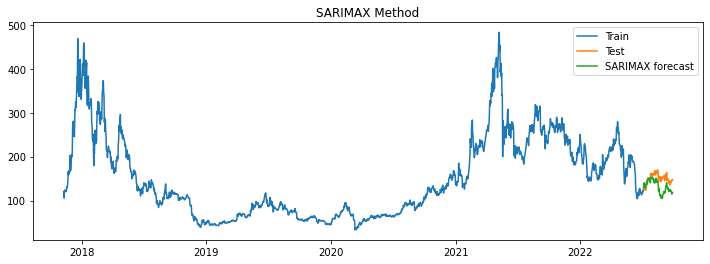

In [96]:
plt.figure(figsize=(12,4))
plt.plot( base['Close'][:train_len], label='Train')
plt.plot(base['Close'][train_len:], label='Test')
plt.plot(y_pred['sarimax_forecast'][test.index.min():], label='SARIMAX forecast')
plt.legend(loc='best')
plt.title('SARIMAX Method')
plt.show()

In [97]:
mse = mean_squared_error(test['Close'], y_pred['sarimax_forecast'][test.index.min():]).round(2)
rmse = np.sqrt(mse).round(2)
r2 = r2_score(test['Close'], y_pred['sarimax_forecast'][test.index.min():]).round(2)
mape = mean_absolute_percentage_error(test['Close'], y_pred['sarimax_forecast'][test.index.min():]).round(4)*100

In [98]:
model_param.loc[4] = ['SARIMAX - BTC data along with FE variables', mse, rmse, r2, mape]
model_param

,model,MSE,RMSE,R-Squared,MAPE
0,ARMA,742.01,27.24,-5.00,16.16
1,ARIMA,742.01,27.24,-5.00,16.16
2,SARIMA,581.36,24.11,-3.70,13.89
3,SARIMAX - BTC Data,93.22,9.66,0.25,5.30
4,SARIMAX - BTC data along with FE variables,535.26,23.14,-3.33,12.84


In [99]:
a = y_pred['sarimax_forecast']
c = pd.DataFrame(a)
c.columns = ['SARIMAX - BTC FE Data']
b = b.join(c)

#### Random Forest
- No external data. Only lag of one day.

In [100]:
xmr_rf = base.copy()
xmr_rf['Close_lag_1'] = xmr_rf['Close'].shift(1)
xmr_rf.dropna(inplace=True)
xmr_rf.head()

,Close,Close_lag_1
Date,,
2017-11-10,105.585999,120.779999
2017-11-11,119.615997,105.585999
2017-11-12,123.856003,119.615997
2017-11-13,123.402000,123.856003
2017-11-14,122.352997,123.402000


In [101]:
rf_crypto = xmr_rf
rf_crypto.head()

,Close,Close_lag_1
Date,,
2017-11-10,105.585999,120.779999
2017-11-11,119.615997,105.585999
2017-11-12,123.856003,119.615997
2017-11-13,123.402000,123.856003
2017-11-14,122.352997,123.402000


In [102]:
y_rf = rf_crypto['Close']
X_rf = rf_crypto.drop('Close', axis=1)

In [103]:
X_rf.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1785 entries, 2017-11-10 to 2022-09-29
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Close_lag_1  1785 non-null   float64
dtypes: float64(1)
memory usage: 27.9 KB


In [104]:
X_rf_train = X_rf[:train_len]
X_rf_test = X_rf[train_len:]
y_rf_train = y_rf[:train_len]
y_rf_test = y_rf[train_len:]

In [105]:
from sklearn.ensemble import RandomForestRegressor

In [106]:
rf_model = RandomForestRegressor(n_estimators=20, max_depth=10, bootstrap=True, oob_score=True, n_jobs=-1)
rf_model.fit(X_rf_train, y_rf_train)

RandomForestRegressor(max_depth=10, n_estimators=20, n_jobs=-1, oob_score=True)

In [107]:
y_rf_pred = rf_model.predict(X_rf_test)

In [108]:
y_rf_test.index

DatetimeIndex(['2022-07-07', '2022-07-08', '2022-07-09', '2022-07-10',
               '2022-07-11', '2022-07-12', '2022-07-13', '2022-07-14',
               '2022-07-15', '2022-07-16', '2022-07-17', '2022-07-18',
               '2022-07-19', '2022-07-20', '2022-07-21', '2022-07-22',
               '2022-07-23', '2022-07-24', '2022-07-25', '2022-07-26',
               '2022-07-27', '2022-07-28', '2022-07-29', '2022-07-30',
               '2022-07-31', '2022-08-01', '2022-08-02', '2022-08-03',
               '2022-08-04', '2022-08-05', '2022-08-06', '2022-08-07',
               '2022-08-08', '2022-08-09', '2022-08-10', '2022-08-11',
               '2022-08-12', '2022-08-13', '2022-08-14', '2022-08-15',
               '2022-08-16', '2022-08-17', '2022-08-18', '2022-08-19',
               '2022-08-20', '2022-08-21', '2022-08-22', '2022-08-23',
               '2022-08-24', '2022-08-25', '2022-08-26', '2022-08-27',
               '2022-08-28', '2022-08-29', '2022-08-30', '2022-08-31',
      

In [109]:
y_rf_pred_df = pd.DataFrame(y_rf_pred)
y_rf_pred_df['Date'] = y_rf_test.index
y_rf_pred_df = y_rf_pred_df.set_index('Date')
y_rf_pred_s = y_rf_pred_df.squeeze()

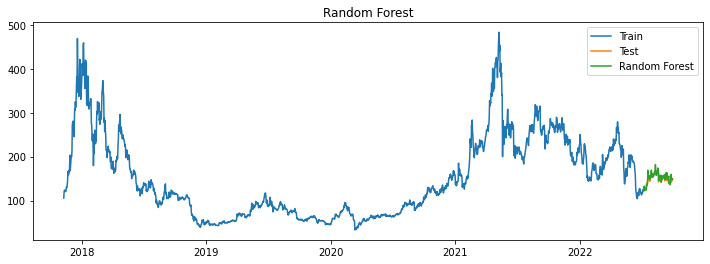

In [110]:
plt.figure(figsize=(12,4))
plt.plot( y_rf_train, label='Train')
plt.plot(y_rf_test, label='Test')
plt.plot(y_rf_pred_s, label='Random Forest')
plt.legend(loc='best')
plt.title('Random Forest')
plt.show()

In [111]:
mse = mean_squared_error(y_rf_test, y_rf_pred_s).round(2)
rmse = np.sqrt(mse).round(2)
r2 = r2_score(y_rf_test, y_rf_pred_s).round(2)
mape = np.round(np.mean(np.abs(y_rf_test - y_rf_pred_s)/y_rf_test)*100,2)

In [112]:
model_param.loc[5] = ['Random Forest - 1 lag, No Ext Var', mse, rmse, r2, mape]
model_param

,model,MSE,RMSE,R-Squared,MAPE
0,ARMA,742.01,27.24,-5.00,16.16
1,ARIMA,742.01,27.24,-5.00,16.16
2,SARIMA,581.36,24.11,-3.70,13.89
3,SARIMAX - BTC Data,93.22,9.66,0.25,5.30
4,SARIMAX - BTC data along with FE variables,535.26,23.14,-3.33,12.84
5,"Random Forest - 1 lag, No Ext Var",51.87,7.20,0.56,3.65


In [113]:
a = y_rf_pred_s
c = pd.DataFrame(a)
c.columns = ['Random Forest - 1 lag, No Ext Var']
b = b.join(c)

#### Random Forest
- Daily lag till 7 days and Feature Engineered data of Bitcoin.

In [114]:
xmr_rf = base.copy()
xmr_rf['Close_lag_1'] = xmr_rf['Close'].shift(1)
xmr_rf['Close_lag_2'] = xmr_rf['Close'].shift(2)
xmr_rf['Close_lag_3'] = xmr_rf['Close'].shift(3)
xmr_rf['Close_lag_4'] = xmr_rf['Close'].shift(4)
xmr_rf['Close_lag_5'] = xmr_rf['Close'].shift(5)
xmr_rf['Close_lag_6'] = xmr_rf['Close'].shift(6)
xmr_rf['Close_lag_7'] = xmr_rf['Close'].shift(7)
xmr_rf.dropna(inplace=True)
xmr_rf.head()

,Close,Close_lag_1,Close_lag_2,Close_lag_3,Close_lag_4,Close_lag_5,Close_lag_6,Close_lag_7
Date,,,,,,,,
2017-11-16,120.305000,121.374001,122.352997,123.402000,123.856003,119.615997,105.585999,120.779999
2017-11-17,126.699997,120.305000,121.374001,122.352997,123.402000,123.856003,119.615997,105.585999
2017-11-18,130.798996,126.699997,120.305000,121.374001,122.352997,123.402000,123.856003,119.615997
2017-11-19,129.479004,130.798996,126.699997,120.305000,121.374001,122.352997,123.402000,123.856003
2017-11-20,135.764999,129.479004,130.798996,126.699997,120.305000,121.374001,122.352997,123.402000


In [115]:
# Bitcoin feature engineered data
X.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1786 entries, 2017-11-09 to 2022-09-29
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Close_btc       1786 non-null   float64
 1   Open_xmr        1786 non-null   float64
 2   volume_em       1786 non-null   float64
 3   volume_sma_em   1786 non-null   float64
 4   volume_nvi      1786 non-null   float64
 5   volatility_bbw  1786 non-null   float64
 6   volatility_kcp  1786 non-null   float64
 7   volatility_ui   1786 non-null   float64
 8   others_dr       1786 non-null   float64
dtypes: float64(9)
memory usage: 139.5 KB


In [116]:
rf_crypto = X.merge(xmr_rf, on='Date')

In [117]:
y_rf = rf_crypto['Close']
X_rf = rf_crypto.drop('Close', axis=1)

X_rf.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1779 entries, 2017-11-16 to 2022-09-29
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Close_btc       1779 non-null   float64
 1   Open_xmr        1779 non-null   float64
 2   volume_em       1779 non-null   float64
 3   volume_sma_em   1779 non-null   float64
 4   volume_nvi      1779 non-null   float64
 5   volatility_bbw  1779 non-null   float64
 6   volatility_kcp  1779 non-null   float64
 7   volatility_ui   1779 non-null   float64
 8   others_dr       1779 non-null   float64
 9   Close_lag_1     1779 non-null   float64
 10  Close_lag_2     1779 non-null   float64
 11  Close_lag_3     1779 non-null   float64
 12  Close_lag_4     1779 non-null   float64
 13  Close_lag_5     1779 non-null   float64
 14  Close_lag_6     1779 non-null   float64
 15  Close_lag_7     1779 non-null   float64
dtypes: float64(16)
memory usage: 236.3 KB


In [118]:
X_rf_train = X_rf[:train_len]
X_rf_test = X_rf[train_len:]
y_rf_train = y_rf[:train_len]
y_rf_test = y_rf[train_len:]

In [119]:
rf_model = RandomForestRegressor(n_estimators=20, max_depth=10, bootstrap=True, oob_score=True, n_jobs=-1)
rf_model.fit(X_rf_train, y_rf_train)

RandomForestRegressor(max_depth=10, n_estimators=20, n_jobs=-1, oob_score=True)

In [120]:
y_rf_pred = rf_model.predict(X_rf_test)

In [121]:
y_rf_test.index

DatetimeIndex(['2022-07-13', '2022-07-14', '2022-07-15', '2022-07-16',
               '2022-07-17', '2022-07-18', '2022-07-19', '2022-07-20',
               '2022-07-21', '2022-07-22', '2022-07-23', '2022-07-24',
               '2022-07-25', '2022-07-26', '2022-07-27', '2022-07-28',
               '2022-07-29', '2022-07-30', '2022-07-31', '2022-08-01',
               '2022-08-02', '2022-08-03', '2022-08-04', '2022-08-05',
               '2022-08-06', '2022-08-07', '2022-08-08', '2022-08-09',
               '2022-08-10', '2022-08-11', '2022-08-12', '2022-08-13',
               '2022-08-14', '2022-08-15', '2022-08-16', '2022-08-17',
               '2022-08-18', '2022-08-19', '2022-08-20', '2022-08-21',
               '2022-08-22', '2022-08-23', '2022-08-24', '2022-08-25',
               '2022-08-26', '2022-08-27', '2022-08-28', '2022-08-29',
               '2022-08-30', '2022-08-31', '2022-09-01', '2022-09-02',
               '2022-09-03', '2022-09-04', '2022-09-05', '2022-09-06',
      

In [122]:
y_rf_pred_df = pd.DataFrame(y_rf_pred)
y_rf_pred_df['Date'] = y_rf_test.index
y_rf_pred_df = y_rf_pred_df.set_index('Date')
y_rf_pred_s = y_rf_pred_df.squeeze()

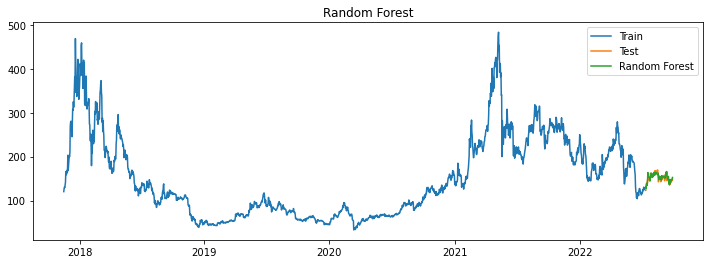

In [123]:
plt.figure(figsize=(12,4))
plt.plot( y_rf_train, label='Train')
plt.plot(y_rf_test, label='Test')
plt.plot(y_rf_pred_s, label='Random Forest')
plt.legend(loc='best')
plt.title('Random Forest')
plt.show()

In [124]:
mse = mean_squared_error(y_rf_test, y_rf_pred_s).round(2)
rmse = np.sqrt(mse).round(2)
r2 = r2_score(y_rf_test, y_rf_pred_s).round(2)
mape = np.round(np.mean(np.abs(y_rf_test - y_rf_pred_s)/y_rf_test)*100,2)

In [125]:
model_param.loc[6] = ['Random Forest - 7 lags with BTC FE Variables', mse, rmse, r2, mape]
model_param

,model,MSE,RMSE,R-Squared,MAPE
0,ARMA,742.01,27.24,-5.00,16.16
1,ARIMA,742.01,27.24,-5.00,16.16
2,SARIMA,581.36,24.11,-3.70,13.89
3,SARIMAX - BTC Data,93.22,9.66,0.25,5.30
4,SARIMAX - BTC data along with FE variables,535.26,23.14,-3.33,12.84
5,"Random Forest - 1 lag, No Ext Var",51.87,7.20,0.56,3.65
6,Random Forest - 7 lags with BTC FE Variables,22.88,4.78,0.73,2.43


In [126]:
a = y_rf_pred_s
c = pd.DataFrame(a)
c.columns = ['Random Forest - 7 lags with BTC FE Variables']
b = b.join(c)

#### Random Forest
- No lag data. Only Feature Engineered Bitcoin variables.

In [127]:
xmr_rf = base.copy()
xmr_rf.head()

,Close
Date,
2017-11-09,120.779999
2017-11-10,105.585999
2017-11-11,119.615997
2017-11-12,123.856003
2017-11-13,123.402000


In [128]:
# Bitcoin feature engineered data
X.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1786 entries, 2017-11-09 to 2022-09-29
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Close_btc       1786 non-null   float64
 1   Open_xmr        1786 non-null   float64
 2   volume_em       1786 non-null   float64
 3   volume_sma_em   1786 non-null   float64
 4   volume_nvi      1786 non-null   float64
 5   volatility_bbw  1786 non-null   float64
 6   volatility_kcp  1786 non-null   float64
 7   volatility_ui   1786 non-null   float64
 8   others_dr       1786 non-null   float64
dtypes: float64(9)
memory usage: 139.5 KB


In [129]:
rf_crypto = X.merge(xmr_rf, on='Date')

In [130]:
y_rf = rf_crypto['Close']
X_rf = rf_crypto.drop('Close', axis=1)

X_rf.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1786 entries, 2017-11-09 to 2022-09-29
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Close_btc       1786 non-null   float64
 1   Open_xmr        1786 non-null   float64
 2   volume_em       1786 non-null   float64
 3   volume_sma_em   1786 non-null   float64
 4   volume_nvi      1786 non-null   float64
 5   volatility_bbw  1786 non-null   float64
 6   volatility_kcp  1786 non-null   float64
 7   volatility_ui   1786 non-null   float64
 8   others_dr       1786 non-null   float64
dtypes: float64(9)
memory usage: 139.5 KB


In [131]:
X_rf_train = X_rf[:train_len]
X_rf_test = X_rf[train_len:]
y_rf_train = y_rf[:train_len]
y_rf_test = y_rf[train_len:]

In [132]:
rf_model = RandomForestRegressor(n_estimators=20, max_depth=10, bootstrap=True, oob_score=True, n_jobs=-1)
rf_model.fit(X_rf_train, y_rf_train)

RandomForestRegressor(max_depth=10, n_estimators=20, n_jobs=-1, oob_score=True)

In [133]:
y_rf_pred = rf_model.predict(X_rf_test)

In [134]:
y_rf_test.index

DatetimeIndex(['2022-07-06', '2022-07-07', '2022-07-08', '2022-07-09',
               '2022-07-10', '2022-07-11', '2022-07-12', '2022-07-13',
               '2022-07-14', '2022-07-15', '2022-07-16', '2022-07-17',
               '2022-07-18', '2022-07-19', '2022-07-20', '2022-07-21',
               '2022-07-22', '2022-07-23', '2022-07-24', '2022-07-25',
               '2022-07-26', '2022-07-27', '2022-07-28', '2022-07-29',
               '2022-07-30', '2022-07-31', '2022-08-01', '2022-08-02',
               '2022-08-03', '2022-08-04', '2022-08-05', '2022-08-06',
               '2022-08-07', '2022-08-08', '2022-08-09', '2022-08-10',
               '2022-08-11', '2022-08-12', '2022-08-13', '2022-08-14',
               '2022-08-15', '2022-08-16', '2022-08-17', '2022-08-18',
               '2022-08-19', '2022-08-20', '2022-08-21', '2022-08-22',
               '2022-08-23', '2022-08-24', '2022-08-25', '2022-08-26',
               '2022-08-27', '2022-08-28', '2022-08-29', '2022-08-30',
      

In [135]:
y_rf_pred_df = pd.DataFrame(y_rf_pred)
y_rf_pred_df['Date'] = y_rf_test.index
y_rf_pred_df = y_rf_pred_df.set_index('Date')
y_rf_pred_s = y_rf_pred_df.squeeze()

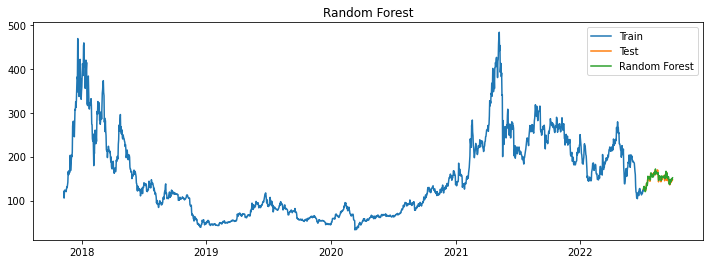

In [136]:
plt.figure(figsize=(12,4))
plt.plot( y_rf_train, label='Train')
plt.plot(y_rf_test, label='Test')
plt.plot(y_rf_pred_s, label='Random Forest')
plt.legend(loc='best')
plt.title('Random Forest')
plt.show()

In [137]:
print(y_rf_test.shape)
print(y_rf_pred_s.shape)

(86,)
(86,)


In [138]:
mse = mean_squared_error(y_rf_test, y_rf_pred_s).round(2)
rmse = np.sqrt(mse).round(2)
r2 = r2_score(test['Close'], y_rf_pred_s).round(2)
mape = np.round(np.mean(np.abs(y_rf_test - y_rf_pred_s)/y_rf_test)*100,2)

In [139]:
model_param.loc[7] = ['Random Forest - No lags with BTC FE Variables', mse, rmse, r2, mape]
model_param

,model,MSE,RMSE,R-Squared,MAPE
0,ARMA,742.01,27.24,-5.00,16.16
1,ARIMA,742.01,27.24,-5.00,16.16
2,SARIMA,581.36,24.11,-3.70,13.89
3,SARIMAX - BTC Data,93.22,9.66,0.25,5.30
4,SARIMAX - BTC data along with FE variables,535.26,23.14,-3.33,12.84
5,"Random Forest - 1 lag, No Ext Var",51.87,7.20,0.56,3.65
6,Random Forest - 7 lags with BTC FE Variables,22.88,4.78,0.73,2.43
7,Random Forest - No lags with BTC FE Variables,23.02,4.80,0.81,2.47


In [140]:
a = y_rf_pred_s
c = pd.DataFrame(a)
c.columns = ['Random Forest - No lags with BTC FE Variables']
b = b.join(c)

#### Random Forest with Scaling

In [141]:
rf_crypto.head()

,Close_btc,Open_xmr,volume_em,volume_sma_em,volume_nvi,volatility_bbw,volatility_kcp,volatility_ui,others_dr,Close
Date,,,,,,,,,,
2017-11-09,7143.580078,112.531998,0.000000,0.000000,1000.000000,0.000000,0.373935,0.0,-64.665181,120.779999
2017-11-10,6618.140137,121.344002,-6716.736347,-6716.736347,1000.000000,15.272508,0.179064,0.0,-7.355415,105.585999
2017-11-11,6357.600098,105.750000,-4575.428295,-5646.082321,960.632438,19.497274,0.122845,0.0,-3.936756,119.615997
2017-11-12,5950.069824,119.597000,-5762.188848,-5684.784497,960.632438,26.569799,0.044458,0.0,-6.410128,123.856003
2017-11-13,6559.490234,128.960007,3947.569949,-3276.695885,1059.022715,23.756538,0.482727,0.0,10.242240,123.402000


In [142]:
train = rf_crypto[0:train_len]
test = rf_crypto[train_len:]
print('train : ', train.shape )
print('test : ', test.shape )

train :  (1700, 10)
test :  (86, 10)


In [143]:
train.describe()

,Close_btc,Open_xmr,volume_em,volume_sma_em,volume_nvi,volatility_bbw,volatility_kcp,volatility_ui,others_dr,Close
count,1700.000000,1700.000000,1700.000000,1700.000000,1700.000000,1700.000000,1700.000000,1700.000000,1700.000000,1700.000000
mean,20158.732018,149.625915,-198.601820,-209.617871,368.536666,26.590340,0.562723,8.786382,0.107451,149.589123
std,17658.394042,91.879410,7365.886554,2379.238598,250.565008,16.502032,0.687060,6.746662,4.377142,91.819814
min,3236.761719,33.084614,-118586.975016,-13387.602225,126.539314,0.000000,-2.194827,0.000000,-64.665181,33.010323
25%,7416.697021,68.629252,-598.385195,-560.085282,199.358990,14.915954,0.126252,3.695153,-1.652779,68.622448
50%,10232.671875,122.127876,3.623237,0.580453,287.408403,23.261321,0.539834,6.767541,0.147657,122.328812
75%,35720.534182,215.299809,652.193095,274.214466,451.693239,33.041535,1.011705,12.192157,1.899809,214.898666
max,67566.828130,483.709991,60625.124126,9442.049952,1471.342938,103.500714,3.021219,34.592181,25.247169,483.583618


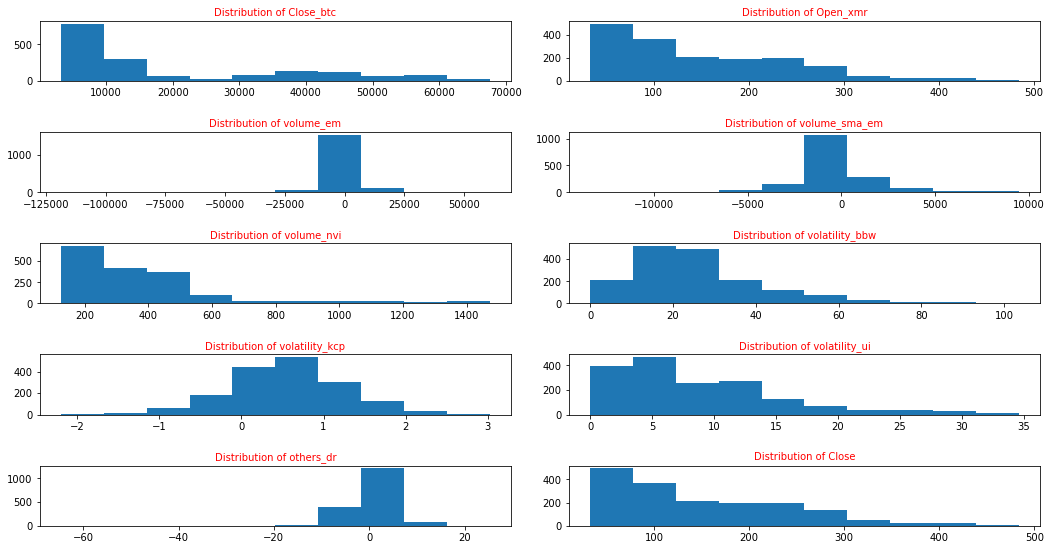

In [144]:
# Check distribution of few variables
plt.figure(figsize=[15,8])

plt.subplot(5,2,1)
plt.title('Distribution of Close_btc', fontsize= 10, color = 'Red', fontweight = 100)
plt.hist(train.Close_btc)

plt.subplot(5,2,2)
plt.title('Distribution of Open_xmr', fontsize= 10, color = 'Red', fontweight = 100)
plt.hist(train.Open_xmr)

plt.subplot(5,2,3)
plt.title('Distribution of volume_em', fontsize= 10, color = 'Red', fontweight = 100)
plt.hist(train.volume_em)

plt.subplot(5,2,4)
plt.title('Distribution of volume_sma_em', fontsize= 10, color = 'Red', fontweight = 100)
plt.hist(train.volume_sma_em)

plt.subplot(5,2,5)
plt.title('Distribution of volume_nvi', fontsize= 10, color = 'Red', fontweight = 100)
plt.hist(train.volume_nvi)

plt.subplot(5,2,6)
plt.title('Distribution of volatility_bbw', fontsize= 10, color = 'Red', fontweight = 100)
plt.hist(train.volatility_bbw)

plt.subplot(5,2,7)
plt.title('Distribution of volatility_kcp', fontsize= 10, color = 'Red', fontweight = 100)
plt.hist(train.volatility_kcp)

plt.subplot(5,2,8)
plt.title('Distribution of volatility_ui', fontsize= 10, color = 'Red', fontweight = 100)
plt.hist(train.volatility_ui)

plt.subplot(5,2,9)
plt.title('Distribution of others_dr', fontsize= 10, color = 'Red', fontweight = 100)
plt.hist(train.others_dr)

plt.subplot(5,2,10)
plt.title('Distribution of Close', fontsize= 10, color = 'Red', fontweight = 100)
plt.hist(train.Close)

plt.tight_layout(pad=2.0)
plt.show()

In [145]:
# Lets try various scalers available in Scikit library. At optimum time, will finalize one.
# Based on various test results, QuantileTransformer with Gaussian distribution seems best suited.
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import RobustScaler
#scaler = MinMaxScaler()
#scaler = StandardScaler()
#scaler = PowerTransformer()
scaler = QuantileTransformer(output_distribution='normal')
#scaler = RobustScaler()

In [146]:
# Identify the variables to be scaled
vars_to_scale = ['Close_btc',
                 'Open_xmr',
                 'volume_em',
                 'volume_sma_em',
                 'volume_nvi',
                 'volatility_bbw',
                 'volatility_kcp',
                 'volatility_ui',
                 'others_dr',
                 'Close']

In [147]:
X_train_sc = train.copy()
X_test_sc = test.copy()

In [148]:
X_train_sc[vars_to_scale] = scaler.fit_transform(train[vars_to_scale])
X_test_sc[vars_to_scale] = scaler.transform(test[vars_to_scale])

In [149]:
X_train_sc.describe()

,Close_btc,Open_xmr,volume_em,volume_sma_em,volume_nvi,volatility_bbw,volatility_kcp,volatility_ui,others_dr,Close
count,1700.000000,1700.000000,1700.000000,1700.000000,1.700000e+03,1700.000000,1700.000000,1700.000000,1700.000000,1700.000000
mean,-0.000064,-0.000038,0.000020,0.000087,9.945859e-05,0.000514,0.000044,-0.017303,0.000059,-0.000004
std,1.011808,1.011634,1.011295,1.011405,1.011494e+00,1.012593,1.011344,1.077993,1.011099,1.011693
min,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338e+00,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338
25%,-0.674498,-0.674555,-0.673779,-0.676256,-6.767490e-01,-0.675501,-0.674351,-0.675086,-0.674647,-0.674856
50%,0.000799,0.000072,0.000153,0.000122,6.960578e-17,-0.000417,0.000093,0.000094,0.000100,0.000631
75%,0.674475,0.674982,0.674443,0.674792,6.742801e-01,0.674397,0.674507,0.676154,0.674388,0.674424
max,5.199338,5.199338,5.199338,5.199338,5.199338e+00,5.199338,5.199338,5.199338,5.199338,5.199338


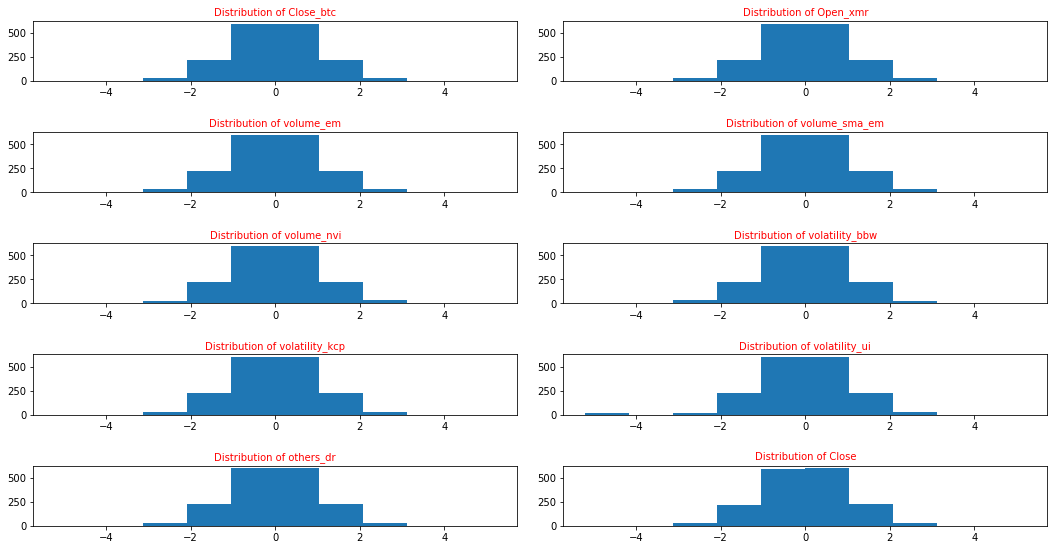

In [150]:
# Check distribution of few variables
plt.figure(figsize=[15,8])

plt.subplot(5,2,1)
plt.title('Distribution of Close_btc', fontsize= 10, color = 'Red', fontweight = 100)
plt.hist(X_train_sc.Close_btc)

plt.subplot(5,2,2)
plt.title('Distribution of Open_xmr', fontsize= 10, color = 'Red', fontweight = 100)
plt.hist(X_train_sc.Open_xmr)

plt.subplot(5,2,3)
plt.title('Distribution of volume_em', fontsize= 10, color = 'Red', fontweight = 100)
plt.hist(X_train_sc.volume_em)

plt.subplot(5,2,4)
plt.title('Distribution of volume_sma_em', fontsize= 10, color = 'Red', fontweight = 100)
plt.hist(X_train_sc.volume_sma_em)

plt.subplot(5,2,5)
plt.title('Distribution of volume_nvi', fontsize= 10, color = 'Red', fontweight = 100)
plt.hist(X_train_sc.volume_nvi)

plt.subplot(5,2,6)
plt.title('Distribution of volatility_bbw', fontsize= 10, color = 'Red', fontweight = 100)
plt.hist(X_train_sc.volatility_bbw)

plt.subplot(5,2,7)
plt.title('Distribution of volatility_kcp', fontsize= 10, color = 'Red', fontweight = 100)
plt.hist(X_train_sc.volatility_kcp)

plt.subplot(5,2,8)
plt.title('Distribution of volatility_ui', fontsize= 10, color = 'Red', fontweight = 100)
plt.hist(X_train_sc.volatility_ui)

plt.subplot(5,2,9)
plt.title('Distribution of others_dr', fontsize= 10, color = 'Red', fontweight = 100)
plt.hist(X_train_sc.others_dr)

plt.subplot(5,2,10)
plt.title('Distribution of Close', fontsize= 10, color = 'Red', fontweight = 100)
plt.hist(X_train_sc.Close)

plt.tight_layout(pad=2.0)
plt.show()

In [151]:
y_train_sc = X_train_sc['Close']
X_train_sc = X_train_sc.drop(['Close'], axis=1)
y_test_sc = X_test_sc['Close']
X_test_sc = X_test_sc.drop(['Close'], axis=1)

In [152]:
print(y_train_sc.shape)
print(X_train_sc.shape)
print(y_test_sc.shape)
print(X_test_sc.shape)

(1700,)
(1700, 9)
(86,)
(86, 9)


In [153]:
rf_model = RandomForestRegressor(n_estimators=20, max_depth=10, bootstrap=True, oob_score=True, n_jobs=-1)
rf_model.fit(X_train_sc, y_train_sc)

RandomForestRegressor(max_depth=10, n_estimators=20, n_jobs=-1, oob_score=True)

In [154]:
y_pred_sc = rf_model.predict(X_test_sc)
y_pred_sc.shape

(86,)

In [155]:
y_test_sc.index

DatetimeIndex(['2022-07-06', '2022-07-07', '2022-07-08', '2022-07-09',
               '2022-07-10', '2022-07-11', '2022-07-12', '2022-07-13',
               '2022-07-14', '2022-07-15', '2022-07-16', '2022-07-17',
               '2022-07-18', '2022-07-19', '2022-07-20', '2022-07-21',
               '2022-07-22', '2022-07-23', '2022-07-24', '2022-07-25',
               '2022-07-26', '2022-07-27', '2022-07-28', '2022-07-29',
               '2022-07-30', '2022-07-31', '2022-08-01', '2022-08-02',
               '2022-08-03', '2022-08-04', '2022-08-05', '2022-08-06',
               '2022-08-07', '2022-08-08', '2022-08-09', '2022-08-10',
               '2022-08-11', '2022-08-12', '2022-08-13', '2022-08-14',
               '2022-08-15', '2022-08-16', '2022-08-17', '2022-08-18',
               '2022-08-19', '2022-08-20', '2022-08-21', '2022-08-22',
               '2022-08-23', '2022-08-24', '2022-08-25', '2022-08-26',
               '2022-08-27', '2022-08-28', '2022-08-29', '2022-08-30',
      

In [156]:
y_pred_sc_df = pd.DataFrame(y_pred_sc)
y_pred_sc_df['Date'] = y_test_sc.index
y_pred_sc_df = y_pred_sc_df.set_index('Date')
X_test_inv_sc = X_test_sc.copy()
X_test_inv_sc['Close_pred'] = y_pred_sc_df[0]
X_test_inv_sc.head()
#y_pred_sc_s = y_pred_sc_df.squeeze()

,Close_btc,Open_xmr,volume_em,volume_sma_em,volume_nvi,volatility_bbw,volatility_kcp,volatility_ui,others_dr,Close_pred
Date,,,,,,,,,,
2022-07-06,0.450827,0.005784,0.685744,0.452947,0.420416,-0.836939,0.435036,0.844249,0.644835,0.031304
2022-07-07,0.464272,0.036601,1.279848,0.769979,0.420416,-0.711921,1.094283,0.509029,1.438976,0.069543
2022-07-08,0.464573,0.090266,0.888280,0.766770,0.420416,-0.739400,1.072924,0.270147,0.142652,0.093312
2022-07-09,0.464126,0.036956,-0.450551,0.721831,0.415124,-0.658726,0.863062,0.059652,-0.341264,0.025147
2022-07-10,0.456694,0.057923,-0.889378,0.553119,0.332869,-0.649498,0.317985,0.041802,-1.106865,0.005935


In [157]:
X_test_inv = scaler.inverse_transform(X_test_inv_sc)
#X_test_inv_sc = pd.DataFrame(X_test_inv_sc)
X_test_inv_df = pd.DataFrame(X_test_inv, columns = ['Close_btc',
                                                    'volume_fi',
                                                    'volume_nvi',
                                                    'volatility_ui',
                                                    'trend_macd_signal',
                                                    'trend_mass_index',
                                                    'trend_dpo',
                                                    'trend_kst_sig',
                                                    'trend_kst_diff',
                                                    'Close'])
X_test_inv_df['Date'] = y_test_sc.index
X_test_inv_df = X_test_inv_df.set_index('Date')
X_test_inv_df.head()

,Close_btc,volume_fi,volume_nvi,volatility_ui,trend_macd_signal,trend_mass_index,trend_dpo,trend_kst_sig,trend_kst_diff,Close
Date,,,,,,,,,,
2022-07-06,20548.24609,122.363937,694.126646,95.171999,405.205200,13.450192,0.815144,13.395579,1.773793,124.224175
2022-07-07,21637.58789,125.533325,4712.908099,366.799300,405.205200,14.589067,1.325506,11.199343,5.301386,128.205821
2022-07-08,21731.11719,130.469330,1594.157860,364.781190,405.205200,14.330037,1.302016,8.960501,0.432254,131.070078
2022-07-09,21592.20703,125.585106,-181.324211,326.407936,402.615038,15.044948,1.158919,7.261155,-0.639222,123.896502
2022-07-10,20860.44922,127.191696,-1513.105778,170.512217,388.970453,15.095766,0.736200,7.107910,-3.388990,122.536714


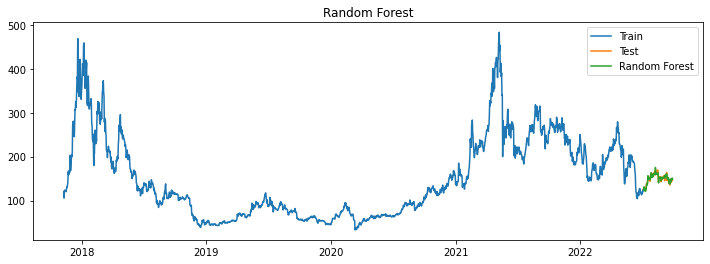

In [158]:
plt.figure(figsize=(12,4))
plt.plot( y_rf_train, label='Train')
plt.plot(y_rf_test, label='Test')
plt.plot(X_test_inv_df['Close'], label='Random Forest')
plt.legend(loc='best')
plt.title('Random Forest')
plt.show()

In [159]:
y_rf_test.shape

(86,)

In [160]:
X_test_inv_df['Close'].shape

(86,)

In [161]:
mse = mean_squared_error(y_rf_test, X_test_inv_df['Close']).round(2)
rmse = np.sqrt(mse).round(2)
r2 = r2_score(y_rf_test, X_test_inv_df['Close']).round(2)
mape = np.round(np.mean(np.abs(y_rf_test - X_test_inv_df['Close'])/y_rf_test)*100,2)

In [162]:
model_param.loc[8] = ['Random Forest - No lags with BTC FE Variables', mse, rmse, r2, mape]
model_param

,model,MSE,RMSE,R-Squared,MAPE
0,ARMA,742.01,27.24,-5.00,16.16
1,ARIMA,742.01,27.24,-5.00,16.16
2,SARIMA,581.36,24.11,-3.70,13.89
3,SARIMAX - BTC Data,93.22,9.66,0.25,5.30
4,SARIMAX - BTC data along with FE variables,535.26,23.14,-3.33,12.84
5,"Random Forest - 1 lag, No Ext Var",51.87,7.20,0.56,3.65
6,Random Forest - 7 lags with BTC FE Variables,22.88,4.78,0.73,2.43
7,Random Forest - No lags with BTC FE Variables,23.02,4.80,0.81,2.47
8,Random Forest - No lags with BTC FE Variables,21.20,4.60,0.83,2.46


In [163]:
a = X_test_inv_df['Close']
c = pd.DataFrame(a)
c.columns = ['Random Forest - No lags with BTC SC FE Variables']
b = b.join(c)

In [164]:
# Random Forest - No lag, XMR base data

In [165]:
xmr_rf = xmr.copy()
xmr_rf = xmr_rf.set_index('Date')
xmr_rf.head()

,Open,High,Low,Close,Volume
Date,,,,,
2017-11-09,112.531998,123.404999,112.219002,120.779999,86864600
2017-11-10,121.344002,121.665001,101.757004,105.585999,84614000
2017-11-11,105.750000,127.106003,103.877998,119.615997,107708000
2017-11-12,119.597000,133.675003,110.617996,123.856003,144948000
2017-11-13,128.960007,136.528000,120.921997,123.402000,116200000


In [166]:
train = xmr_rf[0:train_len]
test = xmr_rf[train_len:]
print('train : ', train.shape )
print('test : ', test.shape )

train :  (1700, 5)
test :  (86, 5)


In [167]:
y_train = train['Close']
X_train = train.drop(['Close'], axis=1)
y_test = test['Close']
X_test = test.drop(['Close'], axis=1)

In [168]:
print(y_train.shape)
print(X_train.shape)
print(y_test.shape)
print(X_test.shape)

(1700,)
(1700, 4)
(86,)
(86, 4)


In [169]:
rf_model = RandomForestRegressor(n_estimators=20, max_depth=10, bootstrap=True, oob_score=True, n_jobs=-1)
rf_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, n_estimators=20, n_jobs=-1, oob_score=True)

In [170]:
y_pred = rf_model.predict(X_test)
y_pred.shape

(86,)

In [171]:
y_pred_df = pd.DataFrame(y_pred)
y_pred_df['Date'] = y_test.index
y_pred_df = y_pred_df.set_index('Date')
y_pred_df['Close'] = y_pred_df[0]
y_pred_df.drop([0], axis=1, inplace=True)

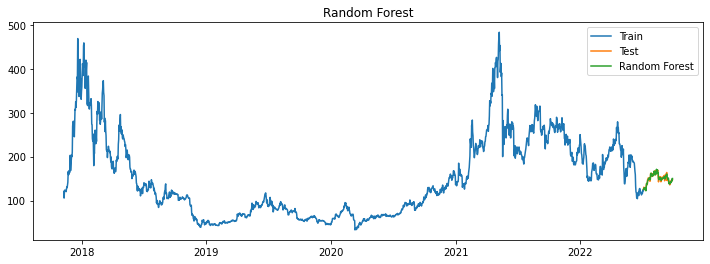

In [172]:
plt.figure(figsize=(12,4))
plt.plot( y_train, label='Train')
plt.plot(y_test, label='Test')
plt.plot(y_pred_df['Close'], label='Random Forest')
plt.legend(loc='best')
plt.title('Random Forest')
plt.show()

In [173]:
mse = mean_squared_error(y_test, y_pred_df).round(2)
rmse = np.sqrt(mse).round(2)
r2 = r2_score(y_test, y_pred_df).round(2)
mape = np.round(np.mean(np.abs(y_test - y_pred_df['Close'])/y_test)*100,2)

In [174]:
model_param.loc[9] = ['Random Forest - No lags with XMR Variables', mse, rmse, r2, mape]
model_param

,model,MSE,RMSE,R-Squared,MAPE
0,ARMA,742.01,27.24,-5.00,16.16
1,ARIMA,742.01,27.24,-5.00,16.16
2,SARIMA,581.36,24.11,-3.70,13.89
3,SARIMAX - BTC Data,93.22,9.66,0.25,5.30
4,SARIMAX - BTC data along with FE variables,535.26,23.14,-3.33,12.84
5,"Random Forest - 1 lag, No Ext Var",51.87,7.20,0.56,3.65
6,Random Forest - 7 lags with BTC FE Variables,22.88,4.78,0.73,2.43
7,Random Forest - No lags with BTC FE Variables,23.02,4.80,0.81,2.47
8,Random Forest - No lags with BTC FE Variables,21.20,4.60,0.83,2.46
9,Random Forest - No lags with XMR Variables,9.73,3.12,0.92,1.67


In [175]:
a = test.copy()
a['pred-close'] = y_pred_df['Close']
c = a['pred-close']
c = pd.DataFrame(c)
c.columns = ['Random Forest - No lags with XMR Variables']
b = b.join(c)

In [176]:
# Random Forest - with lag, XMR base data

In [177]:
xmr_rf = xmr.copy()
xmr_rf = xmr_rf.set_index('Date')
xmr_rf.head()

,Open,High,Low,Close,Volume
Date,,,,,
2017-11-09,112.531998,123.404999,112.219002,120.779999,86864600
2017-11-10,121.344002,121.665001,101.757004,105.585999,84614000
2017-11-11,105.750000,127.106003,103.877998,119.615997,107708000
2017-11-12,119.597000,133.675003,110.617996,123.856003,144948000
2017-11-13,128.960007,136.528000,120.921997,123.402000,116200000


In [178]:
xmr_rf['Close_lag_1'] = xmr_rf['Close'].shift(1)
xmr_rf['Close_lag_2'] = xmr_rf['Close'].shift(2)
xmr_rf['Close_lag_3'] = xmr_rf['Close'].shift(3)
xmr_rf['Close_lag_4'] = xmr_rf['Close'].shift(4)
xmr_rf['Close_lag_5'] = xmr_rf['Close'].shift(5)
xmr_rf['Close_lag_6'] = xmr_rf['Close'].shift(6)
xmr_rf['Close_lag_7'] = xmr_rf['Close'].shift(7)
xmr_rf.dropna(inplace=True)
xmr_rf.head()

,Open,High,Low,Close,Volume,Close_lag_1,Close_lag_2,Close_lag_3,Close_lag_4,Close_lag_5,Close_lag_6,Close_lag_7
Date,,,,,,,,,,,,
2017-11-16,121.242996,128.087997,118.504997,120.305000,74944096,121.374001,122.352997,123.402000,123.856003,119.615997,105.585999,120.779999
2017-11-17,120.014999,126.699997,119.250000,126.699997,47127700,120.305000,121.374001,122.352997,123.402000,123.856003,119.615997,105.585999
2017-11-18,126.595001,135.011993,123.528999,130.798996,62156400,126.699997,120.305000,121.374001,122.352997,123.402000,123.856003,119.615997
2017-11-19,130.720993,133.617996,127.208000,129.479004,42133000,130.798996,126.699997,120.305000,121.374001,122.352997,123.402000,123.856003
2017-11-20,129.496002,140.550995,128.485001,135.764999,59945400,129.479004,130.798996,126.699997,120.305000,121.374001,122.352997,123.402000


In [179]:
train = xmr_rf[0:train_len]
test = xmr_rf[train_len:]
print('train : ', train.shape )
print('test : ', test.shape )

train :  (1700, 12)
test :  (79, 12)


In [180]:
y_train = train['Close']
X_train = train.drop(['Close'], axis=1)
y_test = test['Close']
X_test = test.drop(['Close'], axis=1)

In [181]:
print(y_train.shape)
print(X_train.shape)
print(y_test.shape)
print(X_test.shape)

(1700,)
(1700, 11)
(79,)
(79, 11)


In [182]:
rf_model = RandomForestRegressor(n_estimators=20, max_depth=10, bootstrap=True, oob_score=True, n_jobs=-1)
rf_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, n_estimators=20, n_jobs=-1, oob_score=True)

In [183]:
y_pred = rf_model.predict(X_test)
y_pred.shape

(79,)

In [184]:
y_pred_df = pd.DataFrame(y_pred)
y_pred_df['Date'] = y_test.index
y_pred_df = y_pred_df.set_index('Date')
y_pred_df['Close'] = y_pred_df[0]
y_pred_df.drop([0], axis=1, inplace=True)

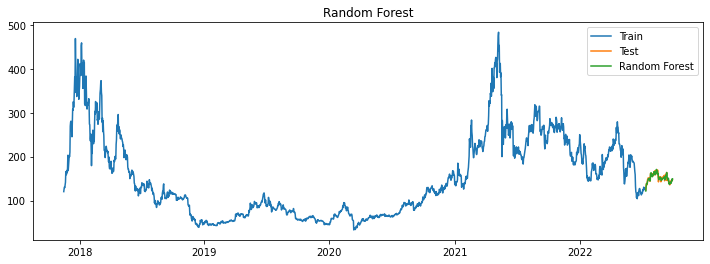

In [185]:
plt.figure(figsize=(12,4))
plt.plot( y_train, label='Train')
plt.plot(y_test, label='Test')
plt.plot(y_pred_df['Close'], label='Random Forest')
plt.legend(loc='best')
plt.title('Random Forest')
plt.show()

In [186]:
mse = mean_squared_error(y_test, y_pred_df).round(2)
rmse = np.sqrt(mse).round(2)
r2 = r2_score(y_test, y_pred_df).round(2)
mape = np.round(np.mean(np.abs(y_test - y_pred_df['Close'])/y_test)*100,2)

In [187]:
model_param.loc[10] = ['Random Forest - With lags and XMR Variables', mse, rmse, r2, mape]
model_param

,model,MSE,RMSE,R-Squared,MAPE
0,ARMA,742.01,27.24,-5.00,16.16
1,ARIMA,742.01,27.24,-5.00,16.16
2,SARIMA,581.36,24.11,-3.70,13.89
3,SARIMAX - BTC Data,93.22,9.66,0.25,5.30
4,SARIMAX - BTC data along with FE variables,535.26,23.14,-3.33,12.84
5,"Random Forest - 1 lag, No Ext Var",51.87,7.20,0.56,3.65
6,Random Forest - 7 lags with BTC FE Variables,22.88,4.78,0.73,2.43
7,Random Forest - No lags with BTC FE Variables,23.02,4.80,0.81,2.47
8,Random Forest - No lags with BTC FE Variables,21.20,4.60,0.83,2.46
9,Random Forest - No lags with XMR Variables,9.73,3.12,0.92,1.67


In [188]:
a = pd.DataFrame(y_pred)
a['Date'] = X_test.index
a = a.set_index('Date')
c = a
c = pd.DataFrame(c)
c.columns = ['Random Forest - With lags and XMR Variables']
b = b.join(c)

In [189]:
# Grid Search
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

In [190]:
xmr_rf = xmr.copy()
xmr_rf = xmr_rf.set_index('Date')
train = xmr_rf[0:train_len]
test = xmr_rf[train_len:]
y_train = train['Close']
X_train = train.drop(['Close'], axis=1)
y_test = test['Close']
X_test = test.drop(['Close'], axis=1)

In [191]:
print(y_train.shape)
print(X_train.shape)
print(y_test.shape)
print(X_test.shape)

(1700,)
(1700, 4)
(86,)
(86, 4)


In [192]:
# Parameter tuining using GridSearch CV
params = {
    'max_depth': [8],
    'n_estimators': [20],
    'max_features': [2, 3, 4],
    'min_samples_split': [3, 5],
    'bootstrap': [True], 
    'oob_score': [True], 
    'n_jobs': [-1],
    'min_samples_leaf':  [3, 5, 7],
    'max_leaf_nodes': [150, 175],
    'random_state':[41, 90, 100]
}

In [193]:
rf_model = RandomForestRegressor()
y_scorer = make_scorer('neg_mean_absolute_percentage_error', greater_is_better=False)
grid_search_rf = GridSearchCV(estimator=rf_model,
                                    param_grid=params,
                                    cv=2, n_jobs=-1, verbose=1, scoring = 'neg_mean_absolute_percentage_error')
grid_search_rf.fit(X_train, y_train)

Fitting 2 folds for each of 108 candidates, totalling 216 fits


GridSearchCV(cv=2, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [8],
                         'max_features': [2, 3, 4],
                         'max_leaf_nodes': [150, 175],
                         'min_samples_leaf': [3, 5, 7],
                         'min_samples_split': [3, 5], 'n_estimators': [20],
                         'n_jobs': [-1], 'oob_score': [True],
                         'random_state': [41, 90, 100]},
             scoring='neg_mean_absolute_percentage_error', verbose=1)

In [194]:
score_df = pd.DataFrame(grid_search_rf.cv_results_)
score_df.sort_values(['rank_test_score'], inplace=True)

In [195]:
dt_best = grid_search_rf.best_estimator_
dt_best

RandomForestRegressor(max_depth=8, max_features=4, max_leaf_nodes=175,
                      min_samples_leaf=3, min_samples_split=5, n_estimators=20,
                      n_jobs=-1, oob_score=True, random_state=90)

In [196]:
rf_model = dt_best
rf_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=8, max_features=4, max_leaf_nodes=175,
                      min_samples_leaf=3, min_samples_split=5, n_estimators=20,
                      n_jobs=-1, oob_score=True, random_state=90)

In [197]:
y_pred = rf_model.predict(X_test)

In [198]:
y_pred_df = pd.DataFrame(y_pred)
y_pred_df['Date'] = y_test.index
y_pred_df = y_pred_df.set_index('Date')
y_pred_df['Close'] = y_pred_df[0]
y_pred_df.drop([0], axis=1, inplace=True)

In [199]:
a = test.copy()
a['pred-close'] = y_pred_df['Close']

In [200]:
a.to_excel('C://Users//nikhi//Desktop//Nikhil//MSC LJMU//Cryptocurrency//Output//XMR//RF Grid Search - No lags and XMR Variables.xlsx')

In [201]:
c = a['pred-close']
c = pd.DataFrame(c)
c.columns = ['RF Grid Search - No lags and XMR Variables']
b = b.join(c)

In [202]:
mse = mean_squared_error(y_test, y_pred_df).round(2)
rmse = np.sqrt(mse).round(2)
r2 = r2_score(y_test, y_pred_df).round(2)
mape = np.round(np.mean(np.abs(y_test - y_pred_df['Close'])/y_test)*100,2)

In [203]:
model_param.loc[11] = ['RF Grid Search - No lags and XMR Variables', mse, rmse, r2, mape]
model_param

,model,MSE,RMSE,R-Squared,MAPE
0,ARMA,742.01,27.24,-5.00,16.16
1,ARIMA,742.01,27.24,-5.00,16.16
2,SARIMA,581.36,24.11,-3.70,13.89
3,SARIMAX - BTC Data,93.22,9.66,0.25,5.30
4,SARIMAX - BTC data along with FE variables,535.26,23.14,-3.33,12.84
5,"Random Forest - 1 lag, No Ext Var",51.87,7.20,0.56,3.65
6,Random Forest - 7 lags with BTC FE Variables,22.88,4.78,0.73,2.43
7,Random Forest - No lags with BTC FE Variables,23.02,4.80,0.81,2.47
8,Random Forest - No lags with BTC FE Variables,21.20,4.60,0.83,2.46
9,Random Forest - No lags with XMR Variables,9.73,3.12,0.92,1.67


#### LSTM

In [204]:
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [205]:
base.head(10)

,Close
Date,
2017-11-09,120.779999
2017-11-10,105.585999
2017-11-11,119.615997
2017-11-12,123.856003
2017-11-13,123.402000
2017-11-14,122.352997
2017-11-15,121.374001
2017-11-16,120.305000
2017-11-17,126.699997


In [206]:
train = base[0:train_len]
test = base[train_len:]

In [207]:
look_back = 1
def dataset_generator_lstm(dataset, look_back = 1):
    dataX, dataY = [], []
    
    for i in range(len(dataset) - look_back):
        window_size_x = dataset[i:(i + look_back)]
        dataX.append(window_size_x)
        dataY.append(dataset[i + look_back])
    return np.array(dataX), np.array(dataY)

trainX, trainY = dataset_generator_lstm(train.Close)

testX, testY = dataset_generator_lstm(test.Close)

print("trainX: ", trainX.shape)
print("trainY: ", trainY.shape)
print("testX: ", testX.shape)
print("testY", testY.shape)

trainX:  (1699, 1)
trainY:  (1699,)
testX:  (85, 1)
testY (85,)


#### Reshaping input to be a 3D Tensor of [samples, time steps, features] for LSTM

In [208]:
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1 ))

print("Shape of trainX: ", trainX.shape)
print("Shape of testX: ", testX.shape)

Shape of trainX:  (1699, 1, 1)
Shape of testX:  (85, 1, 1)


In [209]:
trainX

array([[[120.779999]],

       [[105.585999]],

       [[119.615997]],

       ...,

       [[116.014381]],

       [[116.368416]],

       [[124.015518]]])

In [210]:
print("timesteps in input_shape : ", trainX.shape[1])
print("n_features : ", trainX.shape[2])

timesteps in input_shape :  1
n_features :  1


In [211]:
model = Sequential()
model.add(LSTM(128, activation = 'relu', input_shape = (trainX.shape[1], trainX.shape[2]),return_sequences=True))
model.add(LSTM(64, activation = 'relu', input_shape = (trainX.shape[1], trainX.shape[2]),return_sequences=True))
model.add(LSTM(32, activation = 'relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainX.shape[1]))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 128)            66560     
                                                                 
 lstm_1 (LSTM)               (None, 1, 64)             49408     
                                                                 
 lstm_2 (LSTM)               (None, 32)                12416     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 128,417
Trainable params: 128,417
Non-trainable params: 0
_________________________________________________________________


In [212]:
model.compile(loss='mean_squared_error', optimizer='adam')

In [213]:
checkpoint = ModelCheckpoint(filepath='best_model.hdf5',
                             monitor='val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='min')

earlystopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

callbacks = [checkpoint, earlystopping]

history = model.fit(trainX, trainY, 
                    epochs=500, 
                    batch_size=32, 
                    verbose='auto', 
                    shuffle=False, 
                    validation_data=(testX, testY),
                    callbacks=callbacks)

Epoch 1/500
45/54 [========================>.....] - ETA: 0s - loss: 23864.1191
Epoch 1: val_loss improved from inf to 1840.39197, saving model to best_model.hdf5
54/54 [==============================] - 3s 12ms/step - loss: 22452.0156 - val_loss: 1840.3920
Epoch 2/500
44/54 [=======================>......] - ETA: 0s - loss: 1333.2775
Epoch 2: val_loss improved from 1840.39197 to 290.69144, saving model to best_model.hdf5
54/54 [==============================] - 0s 5ms/step - loss: 1407.5884 - val_loss: 290.6914
Epoch 3/500
45/54 [========================>.....] - ETA: 0s - loss: 956.7679
Epoch 3: val_loss improved from 290.69144 to 283.70813, saving model to best_model.hdf5
54/54 [==============================] - 0s 5ms/step - loss: 1061.7839 - val_loss: 283.7081
Epoch 4/500
50/54 [==========================>...] - ETA: 0s - loss: 1014.0117
Epoch 4: val_loss improved from 283.70813 to 199.84352, saving model to best_model.hdf5
54/54 [==============================] - 0s 5ms/step - lo

In [214]:
result = model.predict(testX, batch_size=1, verbose=0)

In [215]:
result.shape

(85, 1)

In [216]:
result

array([[125.57852 ],
       [130.35562 ],
       [125.69713 ],
       [127.20154 ],
       [129.11937 ],
       [127.053276],
       [123.34509 ],
       [124.151405],
       [133.56976 ],
       [138.53152 ],
       [138.6562  ],
       [135.68242 ],
       [146.79727 ],
       [146.31038 ],
       [150.82765 ],
       [150.18727 ],
       [148.54051 ],
       [145.77635 ],
       [150.62422 ],
       [143.39893 ],
       [150.20152 ],
       [160.37881 ],
       [161.13327 ],
       [158.95226 ],
       [154.71149 ],
       [153.88135 ],
       [159.71101 ],
       [155.6811  ],
       [155.63536 ],
       [158.19795 ],
       [160.41463 ],
       [159.47343 ],
       [163.43747 ],
       [165.7534  ],
       [156.96785 ],
       [166.27591 ],
       [158.90459 ],
       [164.85158 ],
       [165.05911 ],
       [164.1392  ],
       [162.37216 ],
       [168.32103 ],
       [166.98778 ],
       [158.53973 ],
       [142.06615 ],
       [148.26898 ],
       [153.55794 ],
       [152.9

In [217]:
testY.shape

(85,)

In [218]:
pred_df = pd.DataFrame(result, columns = ['Pred_Close'])
pred_df.index = test[look_back:].index
pred_df.tail()

,Pred_Close
Date,
2022-09-25,141.287537
2022-09-26,140.650345
2022-09-27,145.088196
2022-09-28,144.032074
2022-09-29,146.616287


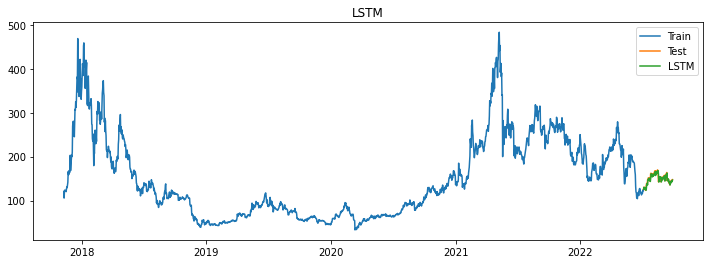

In [219]:
plt.figure(figsize=(12,4))
plt.plot( train, label='Train')
plt.plot(test, label='Test')
plt.plot(pred_df['Pred_Close'], label='LSTM')
plt.legend(loc='best')
plt.title('LSTM')
plt.show()

In [220]:
mse = mean_squared_error(test[look_back:], pred_df['Pred_Close']).round(2)
rmse = np.sqrt(mse).round(2)
r2 = r2_score(test[look_back:], pred_df['Pred_Close']).round(2)
mape = np.round(np.mean(np.abs(test.Close[look_back:] - pred_df['Pred_Close'])/test.Close[look_back:])*100,2)

In [221]:
model_param.loc[12] = ['LSTM - 1 variable and 1 look back', mse, rmse, r2, mape]
model_param

,model,MSE,RMSE,R-Squared,MAPE
0,ARMA,742.01,27.24,-5.00,16.16
1,ARIMA,742.01,27.24,-5.00,16.16
2,SARIMA,581.36,24.11,-3.70,13.89
3,SARIMAX - BTC Data,93.22,9.66,0.25,5.30
4,SARIMAX - BTC data along with FE variables,535.26,23.14,-3.33,12.84
5,"Random Forest - 1 lag, No Ext Var",51.87,7.20,0.56,3.65
6,Random Forest - 7 lags with BTC FE Variables,22.88,4.78,0.73,2.43
7,Random Forest - No lags with BTC FE Variables,23.02,4.80,0.81,2.47
8,Random Forest - No lags with BTC FE Variables,21.20,4.60,0.83,2.46
9,Random Forest - No lags with XMR Variables,9.73,3.12,0.92,1.67


In [222]:
a = test.copy()
a['pred-close'] = y_pred_df['Close']
c = a['pred-close']
c = pd.DataFrame(c)
c.columns = ['LSTM - 1 variable and 1 look back']
b = b.join(c)

In [223]:
# Lookback 7

In [224]:
train = base[0:train_len]
test = base[train_len:]

In [225]:
look_back = 7
def dataset_generator_lstm(dataset, look_back = 7):
    dataX, dataY = [], []
    
    for i in range(len(dataset) - look_back):
        window_size_x = dataset[i:(i + look_back)]
        dataX.append(window_size_x)
        dataY.append(dataset[i + look_back])
    return np.array(dataX), np.array(dataY)

trainX, trainY = dataset_generator_lstm(train.Close)

testX, testY = dataset_generator_lstm(test.Close)

print("trainX: ", trainX.shape)
print("trainY: ", trainY.shape)
print("testX: ", testX.shape)
print("testY", testY.shape)

trainX:  (1693, 7)
trainY:  (1693,)
testX:  (79, 7)
testY (79,)


#### Reshaping input to be a 3D Tensor of [samples, time steps, features] for LSTM

In [226]:
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1 ))

print("Shape of trainX: ", trainX.shape)
print("Shape of testX: ", testX.shape)

Shape of trainX:  (1693, 7, 1)
Shape of testX:  (79, 7, 1)


In [227]:
print("timesteps in input_shape : ", trainX.shape[1])
print("n_features : ", trainX.shape[2])

timesteps in input_shape :  7
n_features :  1


In [228]:
model = Sequential()
model.add(LSTM(128, activation = 'relu', input_shape = (trainX.shape[1], trainX.shape[2]),return_sequences=True))
model.add(LSTM(64, activation = 'relu', input_shape = (trainX.shape[1], trainX.shape[2]),return_sequences=True))
model.add(LSTM(32, activation = 'relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainX.shape[1]))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 7, 128)            66560     
                                                                 
 lstm_4 (LSTM)               (None, 7, 64)             49408     
                                                                 
 lstm_5 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 7)                 231       
                                                                 
Total params: 128,615
Trainable params: 128,615
Non-trainable params: 0
_________________________________________________________________


In [229]:
model.compile(loss='mean_squared_error', optimizer='adam')

In [230]:
checkpoint = ModelCheckpoint(filepath='best_model.hdf5',
                             monitor='val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='min')

earlystopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

callbacks = [checkpoint, earlystopping]

history = model.fit(trainX, trainY, 
                    epochs=500, 
                    batch_size=32, 
                    verbose='auto', 
                    shuffle=False, 
                    validation_data=(testX, testY),
                    callbacks=callbacks)

Epoch 1/500
49/53 [==========================>...] - ETA: 0s - loss: 13574.2031
Epoch 1: val_loss improved from inf to 540.82727, saving model to best_model.hdf5
53/53 [==============================] - 4s 20ms/step - loss: 12873.2451 - val_loss: 540.8273
Epoch 2/500
51/53 [===========================>..] - ETA: 0s - loss: 3562.1072
Epoch 2: val_loss did not improve from 540.82727
53/53 [==============================] - 1s 12ms/step - loss: 3511.5625 - val_loss: 564.0439
Epoch 3/500
51/53 [===========================>..] - ETA: 0s - loss: 3030.3333
Epoch 3: val_loss improved from 540.82727 to 145.69148, saving model to best_model.hdf5
53/53 [==============================] - 1s 15ms/step - loss: 3027.6877 - val_loss: 145.6915
Epoch 4/500
53/53 [==============================] - ETA: 0s - loss: 2665.0225
Epoch 4: val_loss did not improve from 145.69148
53/53 [==============================] - 1s 14ms/step - loss: 2665.0225 - val_loss: 157.3091
Epoch 5/500
49/53 [=======================

Epoch 37/500
51/53 [===========================>..] - ETA: 0s - loss: 926.1068
Epoch 37: val_loss did not improve from 35.56692
53/53 [==============================] - 1s 12ms/step - loss: 927.3019 - val_loss: 142.7892
Epoch 38/500
51/53 [===========================>..] - ETA: 0s - loss: 991.7377
Epoch 38: val_loss did not improve from 35.56692
53/53 [==============================] - 1s 12ms/step - loss: 983.6511 - val_loss: 38.7434


In [231]:
result = model.predict(testX, batch_size=1, verbose=0)

In [232]:
result.shape

(79, 7)

In [233]:
testY.shape

(79,)

In [234]:
pred_df = pd.DataFrame(result, columns = ['Pred_Close', 'lag2', 'lag3', 'lag4', 'lag5', 'lag6', 'lag7'])
pred_df.index = test[look_back:].index
pred_df.tail()

,Pred_Close,lag2,lag3,lag4,lag5,lag6,lag7
Date,,,,,,,
2022-09-25,146.478394,143.814651,144.369629,142.596115,142.921951,143.926880,144.456665
2022-09-26,146.879013,143.962784,144.610825,142.673141,143.045410,144.018295,144.534943
2022-09-27,147.546356,144.626404,145.268494,143.407532,143.706482,144.781998,145.299194
2022-09-28,148.423126,145.988937,146.437256,144.913345,145.279068,146.037308,146.683685
2022-09-29,149.620605,147.019989,147.542252,145.876663,146.114151,147.198700,147.711136


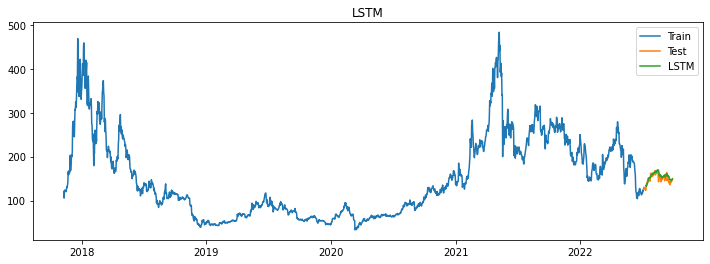

In [235]:
plt.figure(figsize=(12,4))
plt.plot( train, label='Train')
plt.plot(test, label='Test')
plt.plot(pred_df['Pred_Close'], label='LSTM')
plt.legend(loc='best')
plt.title('LSTM')
plt.show()

In [236]:
mse = mean_squared_error(test[look_back:], pred_df['Pred_Close']).round(2)
rmse = np.sqrt(mse).round(2)
r2 = r2_score(test[look_back:], pred_df['Pred_Close']).round(2)
mape = np.round(np.mean(np.abs(test.Close[look_back:] - pred_df['Pred_Close'])/test.Close[look_back:])*100,2)

In [237]:
model_param.loc[13] = ['LSTM - 1 variable and 7 look back', mse, rmse, r2, mape]
model_param

,model,MSE,RMSE,R-Squared,MAPE
0,ARMA,742.01,27.24,-5.00,16.16
1,ARIMA,742.01,27.24,-5.00,16.16
2,SARIMA,581.36,24.11,-3.70,13.89
3,SARIMAX - BTC Data,93.22,9.66,0.25,5.30
4,SARIMAX - BTC data along with FE variables,535.26,23.14,-3.33,12.84
5,"Random Forest - 1 lag, No Ext Var",51.87,7.20,0.56,3.65
6,Random Forest - 7 lags with BTC FE Variables,22.88,4.78,0.73,2.43
7,Random Forest - No lags with BTC FE Variables,23.02,4.80,0.81,2.47
8,Random Forest - No lags with BTC FE Variables,21.20,4.60,0.83,2.46
9,Random Forest - No lags with XMR Variables,9.73,3.12,0.92,1.67


In [238]:
a = pred_df['Pred_Close']
c = a
c = pd.DataFrame(c)
c.columns = ['LSTM - 1 variable and 7 look back']
b = b.join(c)

In [239]:
# LSTM with data from Bitcoin

In [240]:
train = rf_crypto[0:train_len]
test = rf_crypto[train_len:]
print('train : ', train.shape )
print('test : ', test.shape )

train :  (1700, 10)
test :  (86, 10)


In [241]:
train = train[['Close',
                'Close_btc',
                'Open_xmr',
                'volume_em',
                'volume_sma_em',
                'volume_nvi',
                'volatility_bbw',
                'volatility_kcp',
                'volatility_ui',
                'others_dr']]
test = test[['Close',
                'Close_btc',
                'Open_xmr',
                'volume_em',
                'volume_sma_em',
                'volume_nvi',
                'volatility_bbw',
                'volatility_kcp',
                'volatility_ui',
                'others_dr']]

In [242]:
scaler = QuantileTransformer(output_distribution='normal')
vars_to_scale = ['Close',
                    'Close_btc',
                    'Open_xmr',
                    'volume_em',
                    'volume_sma_em',
                    'volume_nvi',
                    'volatility_bbw',
                    'volatility_kcp',
                    'volatility_ui',
                    'others_dr']

In [243]:
train_sc = train.copy()
test_sc = test.copy()

In [244]:
train_sc[vars_to_scale] = scaler.fit_transform(train[vars_to_scale])
test_sc[vars_to_scale] = scaler.transform(test[vars_to_scale])

In [245]:
train_sc.describe()

,Close,Close_btc,Open_xmr,volume_em,volume_sma_em,volume_nvi,volatility_bbw,volatility_kcp,volatility_ui,others_dr
count,1700.000000,1700.000000,1700.000000,1700.000000,1700.000000,1.700000e+03,1700.000000,1700.000000,1700.000000,1700.000000
mean,-0.000004,-0.000064,-0.000038,0.000020,0.000087,9.945859e-05,0.000514,0.000044,-0.017303,0.000059
std,1.011693,1.011808,1.011634,1.011295,1.011405,1.011494e+00,1.012593,1.011344,1.077993,1.011099
min,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338e+00,-5.199338,-5.199338,-5.199338,-5.199338
25%,-0.674856,-0.674498,-0.674555,-0.673779,-0.676256,-6.767490e-01,-0.675501,-0.674351,-0.675086,-0.674647
50%,0.000631,0.000799,0.000072,0.000153,0.000122,6.960578e-17,-0.000417,0.000093,0.000094,0.000100
75%,0.674424,0.674475,0.674982,0.674443,0.674792,6.742801e-01,0.674397,0.674507,0.676154,0.674388
max,5.199338,5.199338,5.199338,5.199338,5.199338,5.199338e+00,5.199338,5.199338,5.199338,5.199338


In [246]:
trainX = []
trainY = []
testX = []
testY = []

In [247]:
n_future = 1
n_past = 2

for i in range (n_past, len(train_sc) - n_future +1):
    trainX.append(train_sc[i - n_past : i])
    trainY.append(train_sc[i + n_future - 1 : i + n_future].Close)
for i in range (n_past, len(test_sc) - n_future +1):
    testX.append(test_sc[i - n_past : i])
    testY.append(test_sc[i + n_future - 1 : i + n_future].Close)

In [248]:
trainX, trainY = np.array(trainX), np.array(trainY)
testX, testY = np.array(testX), np.array(testY)

In [249]:
print (trainX.shape)
print (trainY.shape)
print (testX.shape)
print (testY.shape)

(1698, 2, 10)
(1698, 1)
(84, 2, 10)
(84, 1)


In [250]:
model = Sequential()
model.add(LSTM(128, activation = 'relu', input_shape = (trainX.shape[1], trainX.shape[2]),return_sequences=True))
model.add(LSTM(64, activation = 'relu', input_shape = (trainX.shape[1], trainX.shape[2]),return_sequences=True))
model.add(LSTM(32, activation = 'relu', return_sequences=False))
#model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 2, 128)            71168     
                                                                 
 lstm_7 (LSTM)               (None, 2, 64)             49408     
                                                                 
 lstm_8 (LSTM)               (None, 32)                12416     
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 133,025
Trainable params: 133,025
Non-trainable params: 0
_________________________________________________________________


In [251]:
model.compile(loss='mean_squared_error', optimizer='adam')

checkpoint = ModelCheckpoint(filepath='best_model.hdf5',
                             monitor='val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='min')

earlystopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

callbacks = [checkpoint, earlystopping]

history = model.fit(trainX, trainY, 
                    epochs=500, 
                    batch_size=32, 
                    verbose='auto', 
                    shuffle=False, 
                    validation_data=(testX, testY),
                    callbacks=callbacks)

Epoch 1/500
47/54 [=========================>....] - ETA: 0s - loss: 1.1146
Epoch 1: val_loss improved from inf to 0.03347, saving model to best_model.hdf5
54/54 [==============================] - 3s 12ms/step - loss: 1.0160 - val_loss: 0.0335
Epoch 2/500
46/54 [========================>.....] - ETA: 0s - loss: 0.8113
Epoch 2: val_loss improved from 0.03347 to 0.00797, saving model to best_model.hdf5
54/54 [==============================] - 0s 5ms/step - loss: 0.7115 - val_loss: 0.0080
Epoch 3/500
48/54 [=========================>....] - ETA: 0s - loss: 0.4555
Epoch 3: val_loss improved from 0.00797 to 0.00560, saving model to best_model.hdf5
54/54 [==============================] - 0s 5ms/step - loss: 0.4173 - val_loss: 0.0056
Epoch 4/500
49/54 [==========================>...] - ETA: 0s - loss: 0.3218
Epoch 4: val_loss did not improve from 0.00560
54/54 [==============================] - 0s 5ms/step - loss: 0.2998 - val_loss: 0.0063
Epoch 5/500
46/54 [========================>.....] -

In [252]:
result_sc = model.predict(testX)
result_sc.shape

3/3 [==============================] - 0s 9ms/step


(84, 1)

In [253]:
result_sc = np.repeat(result_sc, 10, axis=-1)
result_sc.shape

(84, 10)

In [254]:
result = scaler.inverse_transform(result_sc)

In [255]:
pred_dates = test.index[:-n_past]
pred_dates.shape

(84,)

In [256]:
result_df = pd.DataFrame(result)
pred_df = pd.DataFrame(result, columns = ['Close', 
                'Close_btc',
                'volume_fi',
                'volume_nvi',
                'volatility_ui',
                'trend_macd_signal',
                'trend_mass_index',
                'trend_dpo',
                'trend_kst_sig',
                'trend_kst_diff'])
pred_df.index = pred_dates
pred_df.head()

,Close,Close_btc,volume_fi,volume_nvi,volatility_ui,trend_macd_signal,trend_mass_index,trend_dpo,trend_kst_sig,trend_kst_diff
Date,,,,,,,,,,
2022-07-06,142.724533,11366.332031,142.876694,53.552422,27.433424,327.998505,25.788441,0.645747,8.216887,0.502590
2022-07-07,139.539459,11290.536133,139.588669,47.159008,24.782520,319.746002,25.496250,0.635780,8.134643,0.473307
2022-07-08,135.721130,10957.649414,135.710678,32.208984,17.262934,306.428558,24.735909,0.613431,7.848281,0.386234
2022-07-09,135.498230,10938.114258,135.363266,31.262384,15.933904,306.097290,24.684683,0.611820,7.789550,0.378998
2022-07-10,133.414597,10834.423828,133.442322,27.620531,14.379408,303.749115,24.510889,0.605648,7.692530,0.356685


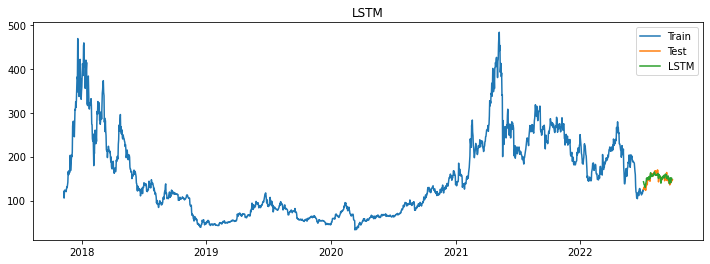

In [257]:
plt.figure(figsize=(12,4))
plt.plot( train['Close'], label='Train')
plt.plot(test['Close'], label='Test')
plt.plot(pred_df['Close'], label='LSTM')
plt.legend(loc='best')
plt.title('LSTM')
plt.show()

In [258]:
mse = mean_squared_error(test['Close'][:-n_past], pred_df['Close']).round(2)
rmse = np.sqrt(mse).round(2)
r2 = r2_score(test['Close'][:-n_past], pred_df['Close']).round(2)
mape = np.round(np.mean(np.abs(test['Close'][:-n_past] - pred_df['Close'])/test['Close'][:-n_past])*100,2)

In [259]:
model_param.loc[14] = ['LSTM - BTC FE variables', mse, rmse, r2, mape]
model_param

,model,MSE,RMSE,R-Squared,MAPE
0,ARMA,742.01,27.24,-5.00,16.16
1,ARIMA,742.01,27.24,-5.00,16.16
2,SARIMA,581.36,24.11,-3.70,13.89
3,SARIMAX - BTC Data,93.22,9.66,0.25,5.30
4,SARIMAX - BTC data along with FE variables,535.26,23.14,-3.33,12.84
5,"Random Forest - 1 lag, No Ext Var",51.87,7.20,0.56,3.65
6,Random Forest - 7 lags with BTC FE Variables,22.88,4.78,0.73,2.43
7,Random Forest - No lags with BTC FE Variables,23.02,4.80,0.81,2.47
8,Random Forest - No lags with BTC FE Variables,21.20,4.60,0.83,2.46
9,Random Forest - No lags with XMR Variables,9.73,3.12,0.92,1.67


In [260]:
a = pred_df['Close']
c = a
c = pd.DataFrame(c)
c.columns = ['LSTM - BTC FE variables']
b = b.join(c)

In [261]:
# LSTM on FE variables of XMR

In [262]:
xmr_fe = xmr.copy()
xmr_fe.head()

,Date,Open,High,Low,Close,Volume
0,2017-11-09,112.531998,123.404999,112.219002,120.779999,86864600
1,2017-11-10,121.344002,121.665001,101.757004,105.585999,84614000
2,2017-11-11,105.750000,127.106003,103.877998,119.615997,107708000
3,2017-11-12,119.597000,133.675003,110.617996,123.856003,144948000
4,2017-11-13,128.960007,136.528000,120.921997,123.402000,116200000


In [263]:
add_all_ta_features(xmr_fe, 
                    open='Open', 
                    high='High', 
                    low='Low', 
                    close='Close', 
                    volume='Volume', 
                    fillna=True)
xmr_fe.head()

,Date,Open,High,Low,Close,Volume,volume_adi,volume_obv,volume_cmf,volume_fi,...,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,momentum_pvo,momentum_pvo_signal,momentum_pvo_hist,momentum_kama,others_dr,others_dlr,others_cr
0,2017-11-09,112.531998,123.404999,112.219002,120.779999,86864600,4.609585e+07,86864600,0.530663,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,120.779999,-19.264772,0.000000,0.000000
1,2017-11-10,121.344002,121.665001,101.757004,105.585999,84614000,-5.969767e+06,2250600,-0.034813,-1.285625e+09,...,-1.012964,-0.202593,-0.810371,-0.207081,-0.041416,-0.165665,117.063051,-12.579897,-13.444492,-12.579897
2,2017-11-11,105.750000,127.106003,103.877998,119.615997,107708000,3.227608e+07,109958600,0.115608,-8.860868e+08,...,-0.859712,-0.334017,-0.525695,1.726950,0.312257,1.414693,117.338100,13.287745,12.476081,-0.963737
3,2017-11-12,119.597000,133.675003,110.617996,123.856003,144948000,5.376969e+07,254906600,0.126775,-6.717058e+08,...,-0.445983,-0.356410,-0.089573,6.286616,1.507129,4.779487,117.712805,3.544681,3.483304,2.546783
4,2017-11-13,128.960007,136.528000,120.921997,123.402000,116200000,-2.549884e+07,138706600,-0.047191,-5.832843e+08,...,-0.148378,-0.314804,0.166426,7.230779,2.651859,4.578920,118.058536,-0.366557,-0.367231,2.170890


In [264]:
xmr_fe.shape

(1786, 92)

In [265]:
y = xmr_fe['Close']
X = xmr_fe.drop('Close', axis=1)

In [266]:
X.shape

(1786, 91)

In [267]:
constant = DropConstantFeatures(tol=0.600)
constant.fit(X)

DropConstantFeatures(tol=0.6)

In [268]:
len(constant.features_to_drop_)

6

In [269]:
constant.features_to_drop_

['volatility_bbhi',
 'volatility_bbli',
 'volatility_kchi',
 'volatility_kcli',
 'trend_psar_up_indicator',
 'trend_psar_down_indicator']

In [270]:
X.drop(constant.features_to_drop_, axis=1, inplace=True)
X.shape

(1786, 85)

In [271]:
duplicates = DropDuplicateFeatures()
duplicates.fit(X)

len(duplicates.features_to_drop_)

0

In [272]:
correlated = DropCorrelatedFeatures(variables=None, method='pearson', threshold=0.7)
correlated.fit(X)

DropCorrelatedFeatures(threshold=0.7)

In [273]:
len(correlated.features_to_drop_)

59

In [274]:
l = list(correlated.features_to_drop_)

In [275]:
X.drop(l, axis=1, inplace=True)
X.shape

(1786, 26)

In [276]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1786 entries, 0 to 1785
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Date               1786 non-null   datetime64[ns]
 1   Open               1786 non-null   float64       
 2   Volume             1786 non-null   int64         
 3   volume_adi         1786 non-null   float64       
 4   volume_cmf         1786 non-null   float64       
 5   volume_fi          1786 non-null   float64       
 6   volume_em          1786 non-null   float64       
 7   volume_sma_em      1786 non-null   float64       
 8   volume_vpt         1786 non-null   float64       
 9   volume_mfi         1786 non-null   float64       
 10  volume_nvi         1786 non-null   float64       
 11  volatility_bbw     1786 non-null   float64       
 12  volatility_kcp     1786 non-null   float64       
 13  volatility_ui      1786 non-null   float64       
 14  trend_ma

In [277]:
smart_correlated = SmartCorrelatedSelection(variables=None, 
                                            method='pearson', 
                                            threshold=0.7, 
                                            missing_values='ignore', 
                                            selection_method='missing_values', 
                                            estimator=None, 
                                            scoring='roc_auc', 
                                            cv=3)
smart_correlated.fit(X)

SmartCorrelatedSelection(threshold=0.7)

In [278]:
smart_correlated.correlated_feature_sets_

[]

In [279]:
len(smart_correlated.features_to_drop_)

0

In [280]:
from sklearn.linear_model import LinearRegression
linear_model = LinearRegression()
SBS_model = SelectByShuffling(estimator=linear_model, scoring="r2", cv=3)
SBS = SBS_model.fit_transform(X, y)

In [281]:
SBS_model.initial_model_performance_

0.9747439964361441

In [282]:
SBS_model.performance_drifts_

{'Open': 6.061095207980239,
 'Volume': -0.003321749109395533,
 'volume_adi': 0.0008884397843353931,
 'volume_cmf': -0.00016982378345931082,
 'volume_fi': 0.001573999258919323,
 'volume_em': 0.004294237474309903,
 'volume_sma_em': 0.00047506795744411967,
 'volume_vpt': 6.776010745801475e-05,
 'volume_mfi': 2.0623029217903266e-05,
 'volume_nvi': -0.0010820918712426408,
 'volatility_bbw': 0.0015269615990591845,
 'volatility_kcp': 0.0046605024603817435,
 'volatility_ui': 0.0007640582311824184,
 'trend_macd': 5.202819319127805e-05,
 'trend_macd_diff': 0.0009218111553574992,
 'trend_mass_index': 0.0001863438153422159,
 'trend_dpo': -8.177393433106417e-05,
 'trend_stc': -8.892563914897345e-06,
 'trend_adx': -2.9311080151694924e-05,
 'trend_adx_pos': 2.7062023134072355e-05,
 'trend_aroon_up': 0.00014255461448908768,
 'trend_aroon_down': 3.8119891004217976e-05,
 'momentum_pvo': 0.00011658545264536802,
 'momentum_pvo_hist': 0.000862083816314918,
 'others_dr': 0.051324840791947546}

In [283]:
sorted_sbs_var = {var: val for var, val in sorted(SBS_model.performance_drifts_.items(), key=lambda item: item[1])}

In [284]:
sorted_sbs_var

{'Volume': -0.003321749109395533,
 'volume_nvi': -0.0010820918712426408,
 'volume_cmf': -0.00016982378345931082,
 'trend_dpo': -8.177393433106417e-05,
 'trend_adx': -2.9311080151694924e-05,
 'trend_stc': -8.892563914897345e-06,
 'volume_mfi': 2.0623029217903266e-05,
 'trend_adx_pos': 2.7062023134072355e-05,
 'trend_aroon_down': 3.8119891004217976e-05,
 'trend_macd': 5.202819319127805e-05,
 'volume_vpt': 6.776010745801475e-05,
 'momentum_pvo': 0.00011658545264536802,
 'trend_aroon_up': 0.00014255461448908768,
 'trend_mass_index': 0.0001863438153422159,
 'volume_sma_em': 0.00047506795744411967,
 'volatility_ui': 0.0007640582311824184,
 'momentum_pvo_hist': 0.000862083816314918,
 'volume_adi': 0.0008884397843353931,
 'trend_macd_diff': 0.0009218111553574992,
 'volatility_bbw': 0.0015269615990591845,
 'volume_fi': 0.001573999258919323,
 'volume_em': 0.004294237474309903,
 'volatility_kcp': 0.0046605024603817435,
 'others_dr': 0.051324840791947546,
 'Open': 6.061095207980239}

In [285]:
sfp = SelectBySingleFeaturePerformance(estimator=LinearRegression(), scoring="r2", cv=3, threshold=0.01)
sfp.fit(X, y)

SelectBySingleFeaturePerformance(estimator=LinearRegression(), scoring='r2',
                                 threshold=0.01)

In [286]:
sorted_sfp_var = {var: val for var, val in sorted(sfp.feature_performance_.items(), key=lambda item: item[1])}
sorted_sfp_var

{'Volume': -45.303552058317905,
 'volume_nvi': -5.779289821257684,
 'volume_vpt': -4.273155832280108,
 'volume_cmf': -4.269866568694176,
 'trend_aroon_up': -4.258504172565089,
 'trend_mass_index': -4.206082536308968,
 'trend_adx': -4.187768859860964,
 'volume_mfi': -4.125478409780541,
 'trend_aroon_down': -4.077273330331442,
 'volatility_ui': -4.070670778819375,
 'volume_fi': -4.0590895256460815,
 'trend_stc': -4.011477196832867,
 'volatility_kcp': -4.00803528791287,
 'trend_adx_pos': -3.9717184880713976,
 'momentum_pvo_hist': -3.971502604979284,
 'others_dr': -3.970506392474142,
 'trend_dpo': -3.9700687151137193,
 'trend_macd_diff': -3.967846571650926,
 'volume_em': -3.9634945646166386,
 'momentum_pvo': -3.9467369622860677,
 'trend_macd': -3.8865374739931693,
 'volume_sma_em': -3.8563769062865774,
 'volatility_bbw': -3.614405597236187,
 'volume_adi': -2.4613256739972686,
 'Open': 0.9712688992061499}

In [287]:
lr = LinearRegression()
lr_model = RecursiveFeatureElimination(estimator=lr, scoring="r2", cv=3)
lr_model.fit_transform(X, y)
lr_model.initial_model_performance_

0.9747439964361441

In [288]:
lr_model.performance_drifts_

{'volume_adi': -0.004798861246202768,
 'volume_fi': -0.0016733592426012578,
 'Volume': -0.0006366548338353484,
 'volume_vpt': -0.0017590988113325157,
 'trend_stc': -4.670796120553877e-05,
 'trend_aroon_down': -9.714757629553095e-05,
 'volume_mfi': -1.3471444515467113e-07,
 'trend_aroon_up': 2.3661766229921e-05,
 'trend_adx': 1.0657770547317647e-05,
 'volume_em': 0.0007086454378432139,
 'volume_nvi': -0.0005626388243895608,
 'volume_sma_em': -0.0002217909226314152,
 'momentum_pvo': -2.0605017876929033e-05,
 'trend_adx_pos': -2.4685112918310104e-05,
 'trend_dpo': -6.0373874362307234e-05,
 'volatility_bbw': -4.065962014188074e-06,
 'trend_macd': -2.2479157125721017e-05,
 'trend_mass_index': -4.675561181932686e-05,
 'momentum_pvo_hist': -2.2673999879874174e-06,
 'volatility_ui': -4.681369121461998e-06,
 'trend_macd_diff': 0.0008000378030010857,
 'Open': 5.260927984609869,
 'others_dr': 0.011921142188077605,
 'volume_cmf': -7.391381720955881e-05,
 'volatility_kcp': 0.00025540267010371043}

In [289]:
sorted_lr_var = {var: val for var, val in sorted(lr_model.performance_drifts_.items(), key=lambda item: item[1])}
sorted_lr_var

{'volume_adi': -0.004798861246202768,
 'volume_vpt': -0.0017590988113325157,
 'volume_fi': -0.0016733592426012578,
 'Volume': -0.0006366548338353484,
 'volume_nvi': -0.0005626388243895608,
 'volume_sma_em': -0.0002217909226314152,
 'trend_aroon_down': -9.714757629553095e-05,
 'volume_cmf': -7.391381720955881e-05,
 'trend_dpo': -6.0373874362307234e-05,
 'trend_mass_index': -4.675561181932686e-05,
 'trend_stc': -4.670796120553877e-05,
 'trend_adx_pos': -2.4685112918310104e-05,
 'trend_macd': -2.2479157125721017e-05,
 'momentum_pvo': -2.0605017876929033e-05,
 'volatility_ui': -4.681369121461998e-06,
 'volatility_bbw': -4.065962014188074e-06,
 'momentum_pvo_hist': -2.2673999879874174e-06,
 'volume_mfi': -1.3471444515467113e-07,
 'trend_adx': 1.0657770547317647e-05,
 'trend_aroon_up': 2.3661766229921e-05,
 'volatility_kcp': 0.00025540267010371043,
 'volume_em': 0.0007086454378432139,
 'trend_macd_diff': 0.0008000378030010857,
 'others_dr': 0.011921142188077605,
 'Open': 5.260927984609869}

In [290]:
X.shape

(1786, 26)

In [291]:
X.drop(['Volume',
        'volume_nvi',
        'volume_cmf',
        'trend_aroon_down',
        'volume_vpt',
        'trend_aroon_up',
        'trend_adx',
        'volume_mfi',
        'trend_stc',
        'trend_macd',
        'trend_adx_pos',
        'momentum_pvo',
        'trend_mass_index',
        'volume_sma_em',
        'volume_adi',
        'volume_fi'
        ], axis=1, inplace=True)

In [292]:
X.shape

(1786, 10)

In [293]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1786 entries, 0 to 1785
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Date               1786 non-null   datetime64[ns]
 1   Open               1786 non-null   float64       
 2   volume_em          1786 non-null   float64       
 3   volatility_bbw     1786 non-null   float64       
 4   volatility_kcp     1786 non-null   float64       
 5   volatility_ui      1786 non-null   float64       
 6   trend_macd_diff    1786 non-null   float64       
 7   trend_dpo          1786 non-null   float64       
 8   momentum_pvo_hist  1786 non-null   float64       
 9   others_dr          1786 non-null   float64       
dtypes: datetime64[ns](1), float64(9)
memory usage: 139.7 KB


In [294]:
xmr_fe = X
xmr_fe['Close'] = y
xmr_fe = xmr_fe.set_index('Date')
xmr_fe.head()

,Open,volume_em,volatility_bbw,volatility_kcp,volatility_ui,trend_macd_diff,trend_dpo,momentum_pvo_hist,others_dr,Close
Date,,,,,,,,,,
2017-11-09,112.531998,0.000000,0.000000,0.588444,0.0,0.000000,28.820122,0.000000,-19.264772,120.779999
2017-11-10,121.344002,-143.544390,26.848555,0.221833,0.0,-0.969646,36.417122,-0.165665,-12.579897,105.585999
2017-11-11,105.750000,81.539942,23.947609,0.624357,0.0,-0.628999,34.272789,1.414693,13.287745,119.615997
2017-11-12,119.597000,105.853706,23.933376,0.676859,0.0,-0.108283,32.140622,4.779487,3.544681,123.856003
2017-11-13,128.960007,88.351183,22.656760,0.618329,0.0,0.198684,30.952122,4.578920,-0.366557,123.402000


In [295]:
vars_to_scale = ['Open',
                 'volume_em',
                 'volatility_bbw',
                 'volatility_kcp',
                 'volatility_ui',
                 'trend_macd_diff',
                 'trend_dpo',
                 'momentum_pvo_hist',
                 'others_dr',
                 'Close']

In [296]:
#train_len = 1700
train = xmr_fe[0:train_len]
test = xmr_fe[train_len:]
print('train : ', train.shape )
print('test : ', test.shape )

train :  (1700, 10)
test :  (86, 10)


In [297]:
train_sc = train.copy()
test_sc = test.copy()

In [298]:
scaler = QuantileTransformer(output_distribution='normal')
train_sc[vars_to_scale] = scaler.fit_transform(train[vars_to_scale])
test_sc[vars_to_scale] = scaler.transform(test[vars_to_scale])

In [299]:
train_sc.head()

,Open,volume_em,volatility_bbw,volatility_kcp,volatility_ui,trend_macd_diff,trend_dpo,momentum_pvo_hist,others_dr,Close
Date,,,,,,,,,,
2017-11-09,-0.125562,-0.042824,-5.199338,0.113949,-5.199338,-0.099742,1.807778,0.155187,-2.749297,-0.016644
2017-11-10,-0.008206,-1.475490,-0.140048,-0.612745,-5.199338,-0.629752,2.074566,0.112722,-2.090105,-0.179133
2017-11-11,-0.178031,1.330264,-0.365140,0.189818,-5.199338,-0.526387,1.976865,0.461225,2.151820,-0.033375
2017-11-12,-0.031975,1.466391,-0.366935,0.294755,-5.199338,-0.177248,1.919612,1.153805,0.792744,0.024493
2017-11-13,0.074839,1.366079,-0.450057,0.175780,-5.199338,0.065016,1.889118,1.120887,-0.119441,0.016621


In [300]:
trainX = []
trainY = []
testX = []
testY = []

In [301]:
n_future = 1
n_past = 2

for i in range (n_past, len(train_sc) - n_future +1):
    trainX.append(train_sc[i - n_past : i])
    trainY.append(train_sc[i + n_future - 1 : i + n_future].Close)
for i in range (n_past, len(test_sc) - n_future +1):
    testX.append(test_sc[i - n_past : i])
    testY.append(test_sc[i + n_future - 1 : i + n_future].Close)

In [302]:
train_sc.head()

,Open,volume_em,volatility_bbw,volatility_kcp,volatility_ui,trend_macd_diff,trend_dpo,momentum_pvo_hist,others_dr,Close
Date,,,,,,,,,,
2017-11-09,-0.125562,-0.042824,-5.199338,0.113949,-5.199338,-0.099742,1.807778,0.155187,-2.749297,-0.016644
2017-11-10,-0.008206,-1.475490,-0.140048,-0.612745,-5.199338,-0.629752,2.074566,0.112722,-2.090105,-0.179133
2017-11-11,-0.178031,1.330264,-0.365140,0.189818,-5.199338,-0.526387,1.976865,0.461225,2.151820,-0.033375
2017-11-12,-0.031975,1.466391,-0.366935,0.294755,-5.199338,-0.177248,1.919612,1.153805,0.792744,0.024493
2017-11-13,0.074839,1.366079,-0.450057,0.175780,-5.199338,0.065016,1.889118,1.120887,-0.119441,0.016621


In [303]:
trainX, trainY = np.array(trainX), np.array(trainY)
testX, testY = np.array(testX), np.array(testY)
print (trainX.shape)
print (trainY.shape)
print (testX.shape)
print (testY.shape)

(1698, 2, 10)
(1698, 1)
(84, 2, 10)
(84, 1)


In [304]:
model = Sequential()
model.add(LSTM(128, activation = 'relu', input_shape = (trainX.shape[1], trainX.shape[2]),return_sequences=True))
model.add(LSTM(64, activation = 'relu', input_shape = (trainX.shape[1], trainX.shape[2]),return_sequences=True))
model.add(LSTM(32, activation = 'relu', return_sequences=False))
#model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 2, 128)            71168     
                                                                 
 lstm_10 (LSTM)              (None, 2, 64)             49408     
                                                                 
 lstm_11 (LSTM)              (None, 32)                12416     
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 133,025
Trainable params: 133,025
Non-trainable params: 0
_________________________________________________________________


In [305]:
model.compile(loss='mean_squared_error', optimizer='adam')

checkpoint = ModelCheckpoint(filepath='best_model.hdf5',
                             monitor='val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='min')

earlystopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

callbacks = [checkpoint, earlystopping]

history = model.fit(trainX, trainY, 
                    epochs=500, 
                    batch_size=32, 
                    verbose='auto', 
                    shuffle=False, 
                    validation_data=(testX, testY),
                    callbacks=callbacks)

Epoch 1/500
47/54 [=========================>....] - ETA: 0s - loss: 1.1220
Epoch 1: val_loss improved from inf to 0.04045, saving model to best_model.hdf5
54/54 [==============================] - 3s 12ms/step - loss: 1.0240 - val_loss: 0.0405
Epoch 2/500
46/54 [========================>.....] - ETA: 0s - loss: 0.8694
Epoch 2: val_loss improved from 0.04045 to 0.00758, saving model to best_model.hdf5
54/54 [==============================] - 0s 6ms/step - loss: 0.7644 - val_loss: 0.0076
Epoch 3/500
45/54 [========================>.....] - ETA: 0s - loss: 1.0551
Epoch 3: val_loss did not improve from 0.00758
54/54 [==============================] - 0s 5ms/step - loss: 0.9363 - val_loss: 0.0564
Epoch 4/500
46/54 [========================>.....] - ETA: 0s - loss: 0.3314
Epoch 4: val_loss improved from 0.00758 to 0.00426, saving model to best_model.hdf5
54/54 [==============================] - 0s 5ms/step - loss: 0.2983 - val_loss: 0.0043
Epoch 5/500
47/54 [=========================>....] -

In [306]:
result_sc = model.predict(testX)
result_sc.shape

3/3 [==============================] - 0s 8ms/step


(84, 1)

In [307]:
result_sc = np.repeat(result_sc, 10, axis=-1)
result_sc.shape

(84, 10)

In [308]:
result = scaler.inverse_transform(result_sc)

In [309]:
pred_dates = test.index[:-n_past]
pred_dates.shape

(84,)

In [310]:
result_df = pd.DataFrame(result)
pred_df = pd.DataFrame(result, columns = ['Close', 
                'Close_btc',
                'volume_fi',
                'volume_nvi',
                'volatility_ui',
                'trend_macd_signal',
                'trend_mass_index',
                'trend_dpo',
                'trend_kst_sig',
                'trend_kst_diff'])
pred_df.index = pred_dates
pred_df.head()

,Close,Close_btc,volume_fi,volume_nvi,volatility_ui,trend_macd_signal,trend_mass_index,trend_dpo,trend_kst_sig,trend_kst_diff
Date,,,,,,,,,,
2022-07-06,123.695419,0.425430,29.299089,0.540554,9.313979,0.156586,-0.324589,-0.477745,0.268301,123.712013
2022-07-07,123.662109,0.420923,29.291300,0.539959,9.308409,0.156319,-0.327912,-0.480202,0.266127,123.668938
2022-07-08,119.709740,0.053856,28.517311,0.512590,8.904588,0.080720,-0.621443,-0.628131,0.050804,119.899117
2022-07-09,122.457733,0.315677,29.090673,0.534662,9.233806,0.131355,-0.386259,-0.523146,0.208500,122.645966
2022-07-10,125.359161,0.537889,29.478226,0.545928,9.441261,0.161894,-0.246716,-0.437772,0.317015,125.323143


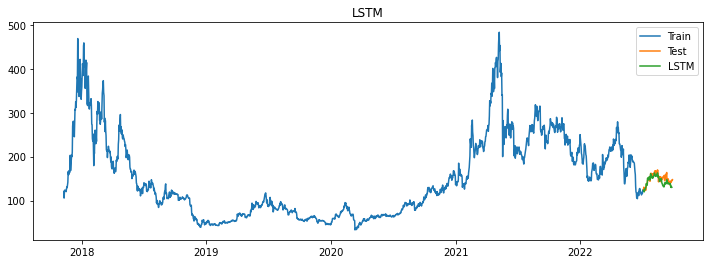

In [311]:
plt.figure(figsize=(12,4))
plt.plot( train['Close'], label='Train')
plt.plot(test['Close'], label='Test')
plt.plot(pred_df['Close'], label='LSTM')
plt.legend(loc='best')
plt.title('LSTM')
plt.show()

In [312]:
mse = mean_squared_error(test['Close'][:-n_past], pred_df['Close']).round(2)
rmse = np.sqrt(mse).round(2)
r2 = r2_score(test['Close'][:-n_past], pred_df['Close']).round(2)
mape = np.round(np.mean(np.abs(test['Close'][:-n_past] - pred_df['Close'])/test['Close'][:-n_past])*100,2)

In [313]:
model_param.loc[15] = ['LSTM - XMR FE Variables', mse, rmse, r2, mape]
model_param

,model,MSE,RMSE,R-Squared,MAPE
0,ARMA,742.01,27.24,-5.00,16.16
1,ARIMA,742.01,27.24,-5.00,16.16
2,SARIMA,581.36,24.11,-3.70,13.89
3,SARIMAX - BTC Data,93.22,9.66,0.25,5.30
4,SARIMAX - BTC data along with FE variables,535.26,23.14,-3.33,12.84
5,"Random Forest - 1 lag, No Ext Var",51.87,7.20,0.56,3.65
6,Random Forest - 7 lags with BTC FE Variables,22.88,4.78,0.73,2.43
7,Random Forest - No lags with BTC FE Variables,23.02,4.80,0.81,2.47
8,Random Forest - No lags with BTC FE Variables,21.20,4.60,0.83,2.46
9,Random Forest - No lags with XMR Variables,9.73,3.12,0.92,1.67


In [314]:
a = pred_df['Close']
c = a
c = pd.DataFrame(c)
c.columns = ['LSTM - XMR FE Variables']
b = b.join(c)

In [315]:
model_param.sort_values('MAPE', ascending=True)

,model,MSE,RMSE,R-Squared,MAPE
11,RF Grid Search - No lags and XMR Variables,9.30,3.05,0.92,1.65
9,Random Forest - No lags with XMR Variables,9.73,3.12,0.92,1.67
10,Random Forest - With lags and XMR Variables,12.24,3.50,0.85,1.81
6,Random Forest - 7 lags with BTC FE Variables,22.88,4.78,0.73,2.43
8,Random Forest - No lags with BTC FE Variables,21.20,4.60,0.83,2.46
7,Random Forest - No lags with BTC FE Variables,23.02,4.80,0.81,2.47
12,LSTM - 1 variable and 1 look back,30.46,5.52,0.74,2.80
13,LSTM - 1 variable and 7 look back,47.03,6.86,0.44,3.44
14,LSTM - BTC FE variables,42.93,6.55,0.66,3.58
5,"Random Forest - 1 lag, No Ext Var",51.87,7.20,0.56,3.65


In [316]:
# Grid Search with XMR FE variables

In [317]:
train = xmr_fe[0:train_len]
test = xmr_fe[train_len:]
print('train : ', train.shape )
print('test : ', test.shape )

train :  (1700, 10)
test :  (86, 10)


In [318]:
y_train = train['Close']
X_train = train.drop(['Close'], axis=1)
y_test = test['Close']
X_test = test.drop(['Close'], axis=1)

In [319]:
print('TRAIN input shape : ', X_train.shape)
print('TRAIN output shape : ', y_train.shape)
print('TEST input shape : ', X_test.shape)
print('TEST output shape : ', y_test.shape)

TRAIN input shape :  (1700, 9)
TRAIN output shape :  (1700,)
TEST input shape :  (86, 9)
TEST output shape :  (86,)


In [320]:
# Parameter tuining using GridSearch CV
params = {
    'max_depth': [10],
    'n_estimators': [20],
    'max_features': [7, 8, 9],
    'min_samples_split': [3, 5],
    'bootstrap': [True], 
    'oob_score': [True], 
    'n_jobs': [-1],
    'min_samples_leaf':  [3, 5],
    'max_leaf_nodes': [175, 200],
    'random_state':[41, 90, 100]
}

In [321]:
rf_model = RandomForestRegressor()
y_scorer = make_scorer('neg_mean_absolute_percentage_error', greater_is_better=False)
grid_search_rf = GridSearchCV(estimator=rf_model,
                                    param_grid=params,
                                    cv=2, n_jobs=-1, verbose=1, scoring = 'neg_mean_absolute_percentage_error')
grid_search_rf.fit(X_train, y_train)

Fitting 2 folds for each of 72 candidates, totalling 144 fits


GridSearchCV(cv=2, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [10],
                         'max_features': [7, 8, 9],
                         'max_leaf_nodes': [175, 200],
                         'min_samples_leaf': [3, 5],
                         'min_samples_split': [3, 5], 'n_estimators': [20],
                         'n_jobs': [-1], 'oob_score': [True],
                         'random_state': [41, 90, 100]},
             scoring='neg_mean_absolute_percentage_error', verbose=1)

In [322]:
score_df = pd.DataFrame(grid_search_rf.cv_results_)
score_df.sort_values(['rank_test_score'], inplace=True)

In [323]:
dt_best = grid_search_rf.best_estimator_
dt_best

RandomForestRegressor(max_depth=10, max_features=9, max_leaf_nodes=200,
                      min_samples_leaf=3, min_samples_split=3, n_estimators=20,
                      n_jobs=-1, oob_score=True, random_state=90)

In [324]:
rf_model = dt_best
rf_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, max_features=9, max_leaf_nodes=200,
                      min_samples_leaf=3, min_samples_split=3, n_estimators=20,
                      n_jobs=-1, oob_score=True, random_state=90)

In [325]:
y_pred = rf_model.predict(X_test)

In [326]:
y_pred_df = pd.DataFrame(y_pred)
y_pred_df['Date'] = y_test.index
y_pred_df = y_pred_df.set_index('Date')
y_pred_df['Close'] = y_pred_df[0]
y_pred_df.drop([0], axis=1, inplace=True)

In [327]:
a = test.copy()
a['pred-close'] = y_pred_df['Close']
a.head()

,Open,volume_em,volatility_bbw,volatility_kcp,volatility_ui,trend_macd_diff,trend_dpo,momentum_pvo_hist,others_dr,Close,pred-close
Date,,,,,,,,,,,
2022-07-06,122.363937,10.527770,19.366090,0.960561,13.112068,3.157074,8.953013,4.160692,2.578842,125.494568,127.326078
2022-07-07,125.533325,30.840829,20.793208,1.321944,10.490024,3.609711,5.989124,4.230098,3.938227,130.436829,131.107399
2022-07-08,130.469330,12.308240,17.524571,0.880753,8.387615,3.493472,-0.015871,3.786911,-3.694977,125.617218,126.702072
2022-07-09,125.585106,-15.272934,17.416318,0.970746,6.532482,3.425676,-3.546385,1.869013,1.238635,127.173157,129.135000
2022-07-10,127.191696,-17.418854,18.012185,1.050433,6.392650,3.411321,-2.953360,3.561938,1.560252,129.157379,129.719384


In [328]:
a.to_excel('C://Users//nikhi//Desktop//Nikhil//MSC LJMU//Cryptocurrency//Output//XMR//RF Grid Search - XMR FE Variables.xlsx')

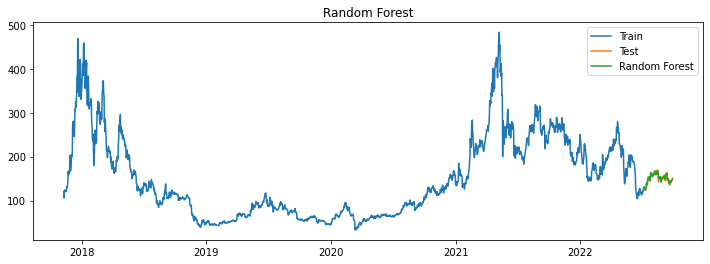

In [329]:
plt.figure(figsize=(12,4))
plt.plot( train['Close'], label='Train')
plt.plot(test['Close'], label='Test')
plt.plot(y_pred_df['Close'], label='Random Forest')
plt.legend(loc='best')
plt.title('Random Forest')
plt.show()

In [330]:
mse = mean_squared_error(y_test, y_pred_df).round(2)
rmse = np.sqrt(mse).round(2)
r2 = r2_score(y_test, y_pred_df).round(2)
mape = np.round(np.mean(np.abs(y_test - y_pred_df['Close'])/y_test)*100,2)

In [331]:
model_param.loc[16] = ['RF Grid Search - XMR FE Variables', mse, rmse, r2, mape]
model_param

,model,MSE,RMSE,R-Squared,MAPE
0,ARMA,742.01,27.24,-5.00,16.16
1,ARIMA,742.01,27.24,-5.00,16.16
2,SARIMA,581.36,24.11,-3.70,13.89
3,SARIMAX - BTC Data,93.22,9.66,0.25,5.30
4,SARIMAX - BTC data along with FE variables,535.26,23.14,-3.33,12.84
5,"Random Forest - 1 lag, No Ext Var",51.87,7.20,0.56,3.65
6,Random Forest - 7 lags with BTC FE Variables,22.88,4.78,0.73,2.43
7,Random Forest - No lags with BTC FE Variables,23.02,4.80,0.81,2.47
8,Random Forest - No lags with BTC FE Variables,21.20,4.60,0.83,2.46
9,Random Forest - No lags with XMR Variables,9.73,3.12,0.92,1.67


In [332]:
a = test.copy()
a['pred-close'] = y_pred_df['Close']
c = a['pred-close']
c = pd.DataFrame(c)
c.columns = ['RF Grid Search - XMR FE Variables']
b = b.join(c)

In [333]:
# Feature importance
imp_df = pd.DataFrame({
    "Varname": X_train.columns,
    "Imp": rf_model.feature_importances_})

imp_df.sort_values(by="Imp", ascending=False)

,Varname,Imp
0,Open,0.987916
8,others_dr,0.009007
1,volume_em,0.001092
3,volatility_kcp,0.001020
7,momentum_pvo_hist,0.000255
2,volatility_bbw,0.000244
5,trend_macd_diff,0.000206
4,volatility_ui,0.000172
6,trend_dpo,0.000088


In [334]:
# Grid Search with XMR FE variables & 1 lag

In [335]:
xmr_lag = xmr_fe.copy()

In [336]:
xmr_lag['Close_lag_1'] = xmr_lag['Close'].shift(1)
xmr_lag.dropna(inplace=True)
xmr_lag.head()

,Open,volume_em,volatility_bbw,volatility_kcp,volatility_ui,trend_macd_diff,trend_dpo,momentum_pvo_hist,others_dr,Close,Close_lag_1
Date,,,,,,,,,,,
2017-11-10,121.344002,-143.544390,26.848555,0.221833,0.0,-0.969646,36.417122,-0.165665,-12.579897,105.585999,120.779999
2017-11-11,105.750000,81.539942,23.947609,0.624357,0.0,-0.628999,34.272789,1.414693,13.287745,119.615997,105.585999
2017-11-12,119.597000,105.853706,23.933376,0.676859,0.0,-0.108283,32.140622,4.779487,3.544681,123.856003,119.615997
2017-11-13,128.960007,88.351183,22.656760,0.618329,0.0,0.198684,30.952122,4.578920,-0.366557,123.402000,123.856003
2017-11-14,123.615997,-76.126153,21.090311,0.588205,0.0,0.317163,30.334622,0.089121,-0.850070,122.352997,123.402000


In [337]:
train = xmr_lag[0:train_len]
test = xmr_lag[train_len:]
print('train : ', train.shape )
print('test : ', test.shape )

train :  (1700, 11)
test :  (85, 11)


In [338]:
y_train = train['Close']
X_train = train.drop(['Close'], axis=1)
y_test = test['Close']
X_test = test.drop(['Close'], axis=1)

In [339]:
print(y_train.shape)
print(X_train.shape)
print(y_test.shape)
print(X_test.shape)

(1700,)
(1700, 10)
(85,)
(85, 10)


In [340]:
# Parameter tuining using GridSearch CV
params = {
    'max_depth': [10, 12, 15],
    'n_estimators': [15, 20],
    'max_features': [8, 9, 10],
    'min_samples_split': [3, 5],
    'bootstrap': [True], 
    'oob_score': [True], 
    'n_jobs': [-1],
    'min_samples_leaf':  [3, 5],
    'max_leaf_nodes': [125, 150, 175],
    'random_state':[21, 41]
}

In [341]:
rf_model = RandomForestRegressor()
y_scorer = make_scorer('neg_mean_absolute_percentage_error', greater_is_better=False)
grid_search_rf = GridSearchCV(estimator=rf_model,
                                    param_grid=params,
                                    cv=2, n_jobs=-1, verbose=1, scoring = 'neg_mean_absolute_percentage_error')
grid_search_rf.fit(X_train, y_train)

Fitting 2 folds for each of 432 candidates, totalling 864 fits


GridSearchCV(cv=2, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [10, 12, 15],
                         'max_features': [8, 9, 10],
                         'max_leaf_nodes': [125, 150, 175],
                         'min_samples_leaf': [3, 5],
                         'min_samples_split': [3, 5], 'n_estimators': [15, 20],
                         'n_jobs': [-1], 'oob_score': [True],
                         'random_state': [21, 41]},
             scoring='neg_mean_absolute_percentage_error', verbose=1)

In [342]:
score_df = pd.DataFrame(grid_search_rf.cv_results_)
score_df.sort_values(['rank_test_score'], inplace=True)

In [343]:
dt_best = grid_search_rf.best_estimator_
dt_best

RandomForestRegressor(max_depth=15, max_features=10, max_leaf_nodes=175,
                      min_samples_leaf=3, min_samples_split=5, n_estimators=15,
                      n_jobs=-1, oob_score=True, random_state=21)

In [344]:
rf_model = dt_best
rf_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=15, max_features=10, max_leaf_nodes=175,
                      min_samples_leaf=3, min_samples_split=5, n_estimators=15,
                      n_jobs=-1, oob_score=True, random_state=21)

In [345]:
y_pred = rf_model.predict(X_test)

In [346]:
y_pred_df = pd.DataFrame(y_pred)
y_pred_df['Date'] = y_test.index
y_pred_df = y_pred_df.set_index('Date')
y_pred_df['Close'] = y_pred_df[0]
y_pred_df.drop([0], axis=1, inplace=True)

In [347]:
a = test.copy()
a['pred-close'] = y_pred_df['Close']

In [348]:
a.to_excel('C://Users//nikhi//Desktop//Nikhil//MSC LJMU//Cryptocurrency//Output//XMR//RF Grid Search - 1 lag with XMR FE Variables.xlsx')

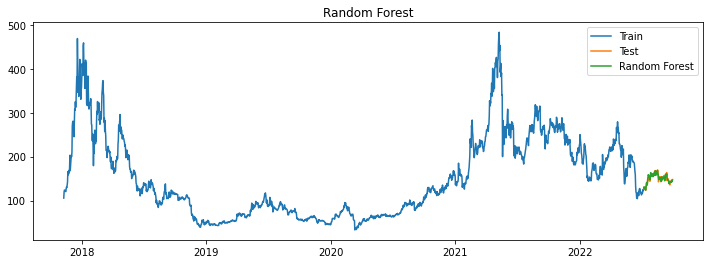

In [349]:
plt.figure(figsize=(12,4))
plt.plot( train['Close'], label='Train')
plt.plot(test['Close'], label='Test')
plt.plot(y_pred_df['Close'], label='Random Forest')
plt.legend(loc='best')
plt.title('Random Forest')
plt.show()

In [350]:
mse = mean_squared_error(y_test, y_pred_df).round(2)
rmse = np.sqrt(mse).round(2)
r2 = r2_score(y_test, y_pred_df).round(2)
mape = np.round(np.mean(np.abs(y_test - y_pred_df['Close'])/y_test)*100,2)

In [351]:
model_param.loc[17] = ['RF Grid Search - 1 lag with XMR FE Variables', mse, rmse, r2, mape]
model_param

,model,MSE,RMSE,R-Squared,MAPE
0,ARMA,742.01,27.24,-5.00,16.16
1,ARIMA,742.01,27.24,-5.00,16.16
2,SARIMA,581.36,24.11,-3.70,13.89
3,SARIMAX - BTC Data,93.22,9.66,0.25,5.30
4,SARIMAX - BTC data along with FE variables,535.26,23.14,-3.33,12.84
5,"Random Forest - 1 lag, No Ext Var",51.87,7.20,0.56,3.65
6,Random Forest - 7 lags with BTC FE Variables,22.88,4.78,0.73,2.43
7,Random Forest - No lags with BTC FE Variables,23.02,4.80,0.81,2.47
8,Random Forest - No lags with BTC FE Variables,21.20,4.60,0.83,2.46
9,Random Forest - No lags with XMR Variables,9.73,3.12,0.92,1.67


In [352]:
a = test.copy()
a['pred-close'] = y_pred_df['Close']
c = a['pred-close']
c = pd.DataFrame(c)
c.columns = ['RF Grid Search - 1 lag with XMR FE Variables']
b = b.join(c)

In [353]:
# LSTM with base XMR variables

In [354]:
xmr_lstm = xmr.copy()

In [355]:
xmr_lstm = xmr_lstm.set_index('Date')
xmr_lstm.head()

,Open,High,Low,Close,Volume
Date,,,,,
2017-11-09,112.531998,123.404999,112.219002,120.779999,86864600
2017-11-10,121.344002,121.665001,101.757004,105.585999,84614000
2017-11-11,105.750000,127.106003,103.877998,119.615997,107708000
2017-11-12,119.597000,133.675003,110.617996,123.856003,144948000
2017-11-13,128.960007,136.528000,120.921997,123.402000,116200000


In [356]:
vars_to_scale = ['Open', 'High', 'Low', 'Close', 'Volume']

In [357]:
#train_len = 1700
train = xmr_lstm[0:train_len]
test = xmr_lstm[train_len:]
print('train : ', train.shape )
print('test : ', test.shape )

train :  (1700, 5)
test :  (86, 5)


In [358]:
train_sc = train.copy()
test_sc = test.copy()

In [359]:
scaler = QuantileTransformer(output_distribution='normal')
train_sc[vars_to_scale] = scaler.fit_transform(train[vars_to_scale])
test_sc[vars_to_scale] = scaler.transform(test[vars_to_scale])

In [360]:
train_sc.head()

,Open,High,Low,Close,Volume
Date,,,,,
2017-11-09,-0.125562,-0.040679,-0.083442,-0.016644,-0.383945
2017-11-10,-0.008206,-0.055884,-0.194612,-0.179133,-0.406226
2017-11-11,-0.178031,0.009255,-0.169606,-0.033375,-0.150706
2017-11-12,-0.031975,0.070422,-0.102611,0.024493,0.158386
2017-11-13,0.074839,0.099963,0.036286,0.016621,-0.069286


In [361]:
trainX = []
trainY = []
testX = []
testY = []

In [362]:
n_future = 1
n_past = 2

for i in range (n_past, len(train_sc) - n_future +1):
    trainX.append(train_sc[i - n_past : i])
    trainY.append(train_sc[i + n_future - 1 : i + n_future].Close)
for i in range (n_past, len(test_sc) - n_future +1):
    testX.append(test_sc[i - n_past : i])
    testY.append(test_sc[i + n_future - 1 : i + n_future].Close)

In [363]:
train_sc.head()

,Open,High,Low,Close,Volume
Date,,,,,
2017-11-09,-0.125562,-0.040679,-0.083442,-0.016644,-0.383945
2017-11-10,-0.008206,-0.055884,-0.194612,-0.179133,-0.406226
2017-11-11,-0.178031,0.009255,-0.169606,-0.033375,-0.150706
2017-11-12,-0.031975,0.070422,-0.102611,0.024493,0.158386
2017-11-13,0.074839,0.099963,0.036286,0.016621,-0.069286


In [364]:
trainX, trainY = np.array(trainX), np.array(trainY)
testX, testY = np.array(testX), np.array(testY)
print (trainX.shape)
print (trainY.shape)
print (testX.shape)
print (testY.shape)

(1698, 2, 5)
(1698, 1)
(84, 2, 5)
(84, 1)


In [365]:
model = Sequential()
model.add(LSTM(64, activation = 'relu', input_shape = (trainX.shape[1], trainX.shape[2]),return_sequences=True))
model.add(LSTM(32, activation = 'relu', input_shape = (trainX.shape[1], trainX.shape[2]),return_sequences=True))
model.add(LSTM(16, activation = 'relu', return_sequences=False))
#model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 2, 64)             17920     
                                                                 
 lstm_13 (LSTM)              (None, 2, 32)             12416     
                                                                 
 lstm_14 (LSTM)              (None, 16)                3136      
                                                                 
 dense_4 (Dense)             (None, 1)                 17        
                                                                 
Total params: 33,489
Trainable params: 33,489
Non-trainable params: 0
_________________________________________________________________


In [366]:
model.compile(loss='mean_squared_error', optimizer='adam')

checkpoint = ModelCheckpoint(filepath='best_model.hdf5',
                             monitor='val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='min')

earlystopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

callbacks = [checkpoint, earlystopping]

history = model.fit(trainX, trainY, 
                    epochs=500, 
#                    batch_size=32, 
                    batch_size=24,
                    verbose='auto', 
                    shuffle=False, 
                    validation_data=(testX, testY),
                    callbacks=callbacks)

Epoch 1/500
56/71 [======================>.......] - ETA: 0s - loss: 1.1154
Epoch 1: val_loss improved from inf to 0.03059, saving model to best_model.hdf5
71/71 [==============================] - 3s 8ms/step - loss: 1.0087 - val_loss: 0.0306
Epoch 2/500
59/71 [=======================>......] - ETA: 0s - loss: 1.0396
Epoch 2: val_loss did not improve from 0.03059
71/71 [==============================] - 0s 3ms/step - loss: 0.9043 - val_loss: 0.0430
Epoch 3/500
68/71 [===========================>..] - ETA: 0s - loss: 0.8783
Epoch 3: val_loss improved from 0.03059 to 0.01033, saving model to best_model.hdf5
71/71 [==============================] - 0s 4ms/step - loss: 0.8458 - val_loss: 0.0103
Epoch 4/500
66/71 [==========================>...] - ETA: 0s - loss: 0.3211
Epoch 4: val_loss improved from 0.01033 to 0.00320, saving model to best_model.hdf5
71/71 [==============================] - 0s 4ms/step - loss: 0.3031 - val_loss: 0.0032
Epoch 5/500
64/71 [==========================>...] - 

Epoch 37/500
60/71 [========================>.....] - ETA: 0s - loss: 0.0362
Epoch 37: val_loss did not improve from 0.00159
71/71 [==============================] - 0s 4ms/step - loss: 0.0323 - val_loss: 0.0016
Epoch 38/500
59/71 [=======================>......] - ETA: 0s - loss: 0.0360
Epoch 38: val_loss did not improve from 0.00159
71/71 [==============================] - 0s 4ms/step - loss: 0.0319 - val_loss: 0.0016
Epoch 39/500
57/71 [=======================>......] - ETA: 0s - loss: 0.0355
Epoch 39: val_loss did not improve from 0.00159
71/71 [==============================] - 0s 4ms/step - loss: 0.0313 - val_loss: 0.0018
Epoch 40/500
57/71 [=======================>......] - ETA: 0s - loss: 0.0352
Epoch 40: val_loss did not improve from 0.00159
71/71 [==============================] - 0s 4ms/step - loss: 0.0310 - val_loss: 0.0017
Epoch 41/500
59/71 [=======================>......] - ETA: 0s - loss: 0.0344
Epoch 41: val_loss improved from 0.00159 to 0.00150, saving model to best_m

In [367]:
result_sc = model.predict(testX)
result_sc.shape

3/3 [==============================] - 0s 4ms/step


(84, 1)

In [368]:
result_sc = np.repeat(result_sc, 5, axis=-1)
result_sc.shape

(84, 5)

In [369]:
result = scaler.inverse_transform(result_sc)

In [370]:
pred_dates = test.index[:-n_past]
pred_dates.shape

(84,)

In [371]:
result_df = pd.DataFrame(result)
pred_df = pd.DataFrame(result, columns = ['Open', 'High', 'Low', 'Close', 'Volume'])
pred_df.index = pred_dates
pred_df.head()

,Open,High,Low,Close,Volume
Date,,,,,
2022-07-06,126.191727,129.916046,121.171455,126.050316,128713856.0
2022-07-07,127.997963,133.538925,122.881607,127.861473,131880960.0
2022-07-08,126.346024,130.241928,121.388016,126.322906,128812048.0
2022-07-09,126.458633,130.400269,121.423149,126.388268,129045656.0
2022-07-10,127.885925,133.413940,122.718636,127.647156,131811648.0


In [372]:
a = test.copy()
a['pred-close'] = y_pred_df['Close']
a.head()

,Open,High,Low,Close,Volume,pred-close
Date,,,,,,
2022-07-06,122.363937,126.687569,121.200478,125.494568,107952769,NaN
2022-07-07,125.533325,131.388611,125.255814,130.436829,87061683,129.793634
2022-07-08,130.469330,133.547897,125.617218,125.617218,81208946,127.069763
2022-07-09,125.585106,128.924927,125.246979,127.173157,60121922,128.929435
2022-07-10,127.191696,129.157379,120.876244,129.157379,98369503,130.759164


In [373]:
a.to_excel('C://Users//nikhi//Desktop//Nikhil//MSC LJMU//Cryptocurrency//Output//XMR//LSTM - XMR base Variables.xlsx')

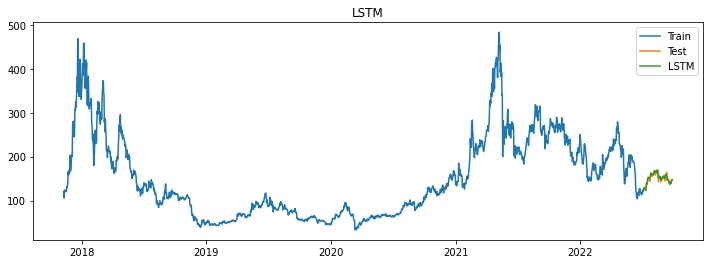

In [374]:
plt.figure(figsize=(12,4))
plt.plot( train['Close'], label='Train')
plt.plot(test['Close'], label='Test')
plt.plot(pred_df['Close'], label='LSTM')
plt.legend(loc='best')
plt.title('LSTM')
plt.show()

In [375]:
mse = mean_squared_error(test['Close'][:-n_past], pred_df['Close']).round(2)
rmse = np.sqrt(mse).round(2)
r2 = r2_score(test['Close'][:-n_past], pred_df['Close']).round(2)
mape = np.round(np.mean(np.abs(test['Close'][:-n_past] - pred_df['Close'])/test['Close'][:-n_past])*100,2)

In [376]:
model_param.loc[18] = ['LSTM - XMR base Variables', mse, rmse, r2, mape]
model_param

,model,MSE,RMSE,R-Squared,MAPE
0,ARMA,742.01,27.24,-5.00,16.16
1,ARIMA,742.01,27.24,-5.00,16.16
2,SARIMA,581.36,24.11,-3.70,13.89
3,SARIMAX - BTC Data,93.22,9.66,0.25,5.30
4,SARIMAX - BTC data along with FE variables,535.26,23.14,-3.33,12.84
5,"Random Forest - 1 lag, No Ext Var",51.87,7.20,0.56,3.65
6,Random Forest - 7 lags with BTC FE Variables,22.88,4.78,0.73,2.43
7,Random Forest - No lags with BTC FE Variables,23.02,4.80,0.81,2.47
8,Random Forest - No lags with BTC FE Variables,21.20,4.60,0.83,2.46
9,Random Forest - No lags with XMR Variables,9.73,3.12,0.92,1.67


In [377]:
a = pred_df['Close']
c = pd.DataFrame(a)
c.columns = ['LSTM - XMR base Variables']
b = b.join(c)

In [378]:
model_param.sort_values('MAPE', ascending=True)

,model,MSE,RMSE,R-Squared,MAPE
16,RF Grid Search - XMR FE Variables,4.84,2.20,0.96,1.12
17,RF Grid Search - 1 lag with XMR FE Variables,9.39,3.06,0.92,1.55
18,LSTM - XMR base Variables,8.85,2.97,0.93,1.56
11,RF Grid Search - No lags and XMR Variables,9.30,3.05,0.92,1.65
9,Random Forest - No lags with XMR Variables,9.73,3.12,0.92,1.67
10,Random Forest - With lags and XMR Variables,12.24,3.50,0.85,1.81
6,Random Forest - 7 lags with BTC FE Variables,22.88,4.78,0.73,2.43
8,Random Forest - No lags with BTC FE Variables,21.20,4.60,0.83,2.46
7,Random Forest - No lags with BTC FE Variables,23.02,4.80,0.81,2.47
12,LSTM - 1 variable and 1 look back,30.46,5.52,0.74,2.80


In [379]:
b.dropna(inplace=True)
b.to_excel('C://Users//nikhi//Desktop//Nikhil//MSC LJMU//Cryptocurrency//Output//XMR//outputs.xlsx')